# Implémentation

In [102]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
os.getcwd()

'C:\\Users\\chiqu\\Documents\\Openclassrooms\\OC_P7\\Projet7'

In [4]:
#os.chdir("C://Users//chiqu//Documents//Openclassrooms//OC_P7")
#os.getcwd()

## Preprocessing

### Data frame building

In [3]:
import re


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    #df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    #test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


num_rows = None
df = application_train_test(num_rows)

print(df.shape)

Train samples: 307511, test samples: 48744
(356251, 248)


In [4]:


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
    # Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg



with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
print(df.shape)


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 20s
(356251, 798)


In [103]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [6]:
df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [7]:
df['TARGET'].value_counts(normalize=True).mul(100)

0.0    91.927013
1.0     8.072987
Name: TARGET, dtype: float64

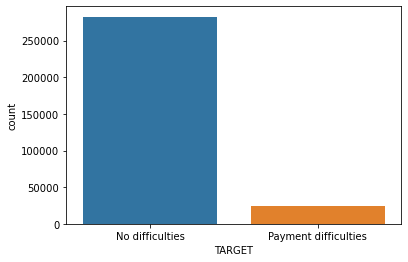

In [8]:
# visualize the target variable
g = sns.countplot(df['TARGET'])
g.set_xticklabels(['No difficulties','Payment difficulties'])
plt.show()

### Data cleaning

#### Infinity values

In [12]:
#Repérage des inf
np.isinf(df).values.sum()

21

In [104]:
#Remplacement des inf par NaN
df_inf = df.replace([np.inf, -np.inf], np.nan)
print(df.shape)
print(df_inf.shape)

(356251, 798)
(356251, 798)


#### Missing values

In [105]:
train_df_inf = df_inf[df_inf['TARGET'].notnull()]
test_df_inf = df_inf[df_inf['TARGET'].isnull()]

<AxesSubplot:>

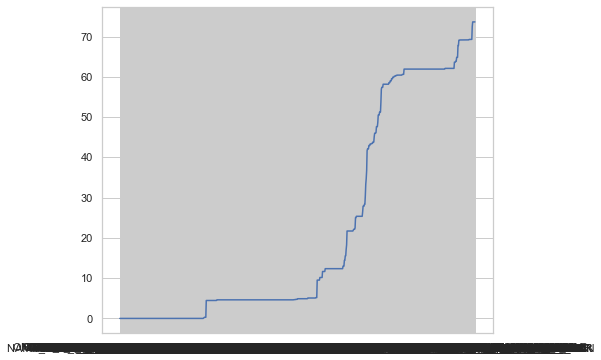

In [106]:
#Repérage des NaN
nan_values = train_df_inf.isna().sum().sort_values(ascending=True)
rate_nan_values = nan_values.sort_values(ascending=True)*100/(df.shape[0])
sns.lineplot(data=rate_nan_values)

In [33]:
rate_nan_values

index                                     0.000000
ORGANIZATION_TYPE_Security                0.000000
ORGANIZATION_TYPE_Security Ministries     0.000000
ORGANIZATION_TYPE_Self-employed           0.000000
ORGANIZATION_TYPE_Services                0.000000
                                           ...    
NONLIVINGAPARTMENTS_AVG                  59.933025
NONLIVINGAPARTMENTS_MODE                 59.933025
COMMONAREA_AVG                           60.311971
COMMONAREA_MODE                          60.311971
COMMONAREA_MEDI                          60.311971
Length: 248, dtype: float64

In [34]:
type(rate_nan_values)

pandas.core.series.Series

In [17]:
rate_nan_values[rate_nan_values.index == 'EXT_SOURCE_3']

EXT_SOURCE_3    17.112934
dtype: float64

In [18]:
rate_nan_values[rate_nan_values.index == 'EXT_SOURCE_1']

EXT_SOURCE_1    48.666811
dtype: float64

In [47]:
df_rate_nan_values= pd.DataFrame(rate_nan_values, columns=['rate_nan'])
df_rate_nan_values.index.name = 'feature'
df_rate_nan_values.reset_index(inplace=True)
df_rate_nan_values

,feature,rate_nan
0,index,0.000000
1,ORGANIZATION_TYPE_Security Ministries,0.000000
2,ORGANIZATION_TYPE_Self-employed,0.000000
3,ORGANIZATION_TYPE_Services,0.000000
4,ORGANIZATION_TYPE_Trade: type 1,0.000000
...,...,...
793,REFUSED_RATE_DOWN_PAYMENT_MAX,73.638811
794,REFUSED_AMT_DOWN_PAYMENT_MIN,73.638811
795,REFUSED_AMT_DOWN_PAYMENT_MEAN,73.638811
796,REFUSED_RATE_DOWN_PAYMENT_MEAN,73.638811


In [66]:
best_features_lgbmc = pd.read_csv('best_features.csv')
best_features_lgbmc 

,feature,importance
0,PAYMENT_RATE,1159.6
1,EXT_SOURCE_1,1044.7
2,EXT_SOURCE_3,1001.5
3,EXT_SOURCE_2,937.8
4,DAYS_BIRTH,765.3
5,AMT_ANNUITY,553.0
6,DAYS_EMPLOYED,546.6
7,DAYS_ID_PUBLISH,462.5
8,APPROVED_CNT_PAYMENT_MEAN,448.1
9,ACTIVE_DAYS_CREDIT_MAX,428.3


In [67]:
best_features_lgbmc_rate_nan = pd.merge(best_features_lgbmc, df_rate_nan_values)
best_features_lgbmc_rate_nan 

,feature,importance,rate_nan
0,PAYMENT_RATE,1159.6,0.003368
1,EXT_SOURCE_1,1044.7,48.666811
2,EXT_SOURCE_3,1001.5,17.112934
3,EXT_SOURCE_2,937.8,0.185263
4,DAYS_BIRTH,765.3,0.000000
5,AMT_ANNUITY,553.0,0.003368
6,DAYS_EMPLOYED,546.6,15.543535
7,DAYS_ID_PUBLISH,462.5,0.000000
8,APPROVED_CNT_PAYMENT_MEAN,448.1,4.897109
9,ACTIVE_DAYS_CREDIT_MAX,428.3,25.364420


In [ ]:
#Variables qu'on conserve même s'il y a un taux de NaN élévé car importantes
#best_features_lgbmc_NaN = ['']

In [ ]:
#On les exclus donc des variables potientellement supprimables
#exclude = df_inf.drop(best_features_lgbmc_NaN,1,inplace=True)
#nan_values = exclude.isna().sum().sort_values(ascending=True)
#rate_nan_values = nan_values.sort_values(ascending=True)*100/(df.shape[0])

In [14]:
print(train_df_inf.shape)

(307507, 798)


In [107]:
# Dropping features rate NaN >30%

# Divide in training/validation and test data
train_df_inf = df_inf[df_inf['TARGET'].notnull()]
test_df_inf = df_inf[df_inf['TARGET'].isnull()]

rate_nan_values = train_df_inf.isna().sum().sort_values(ascending=True)*100/(train_df_inf.shape[0])

#suppression colonnes avec plus de 30% de données manquantes
column_30nan = rate_nan_values[rate_nan_values > 30]
train_df30 = train_df_inf.drop(column_30nan.index,1)
#suppression des lignes avec données manquantes dans train_df
#index_with_nan = train_df30.index[train_df30.isnull().any(axis=1)]
#train_df30.drop(index_with_nan,0, inplace=True)

#test_df avec colonnes retenues
col = train_df30.columns
test_df30 =  test_df_inf[col]
test_df30.drop('TARGET',axis = 1, inplace=True)
#suppression des lignes avec données manquantes dans test_df
#index_with_nan = test_df30.index[test_df30.isnull().any(axis=1)]
#test_df30.drop(index_with_nan,0, inplace=True)
print(train_df30.shape)
print(test_df30.shape)

(307507, 545)
(48744, 544)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [108]:
#suppression des lignes avec données manquantes dans train_df30

#train_df30 : train_df tq features avec plus de 30% NaN sont supprimées
index_with_nan = train_df30.index[train_df30.isnull().any(axis=1)]
train_df30r = train_df30.drop(index_with_nan,0)
print(train_df30r.shape)

#suppression des lignes avec données manquantes dans test_df
index_with_nan = test_df30.index[test_df30.isnull().any(axis=1)]
test_df30r = test_df30.drop(index_with_nan,0)
print(test_df30r.shape)
test_df30r.drop(['index'],axis=1,inplace=True)
test_df30r.to_csv('test_df30r.csv', index=False)

(102240, 545)
(17361, 544)


In [109]:
print(test_df30r.shape)

(17361, 543)


In [110]:
#On vérifie que les variables importantes sont tjrs là
#train_df30[best_features_lgbmc_NaN]

In [111]:
# Dropping features rate NaN >20%

#suppression colonnes avec plus de 20% de données manquantes
column_20nan = rate_nan_values[rate_nan_values > 20]
train_df20 = train_df_inf.drop(column_20nan.index,1)
#suppression des lignes avec données manquantes dans train_df
#index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
#train_df20.drop(index_with_nan,0, inplace=True)

#test_df avec colonnes retenues
col = train_df20.columns
test_df20 =  test_df_inf[col]
test_df20.drop('TARGET',axis = 1, inplace=True)
#suppression des lignes avec données manquantes dans test_df
#index_with_nan = test_df20.index[test_df20.isnull().any(axis=1)]
#test_df20.drop(index_with_nan,0, inplace=True)
print(train_df20.shape)
print(test_df20.shape)

(307507, 509)
(48744, 508)


In [112]:
#suppression des lignes avec données manquantes dans train_df20

#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées

index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

#suppression des lignes avec données manquantes dans test_df
index_with_nan = test_df20.index[test_df20.isnull().any(axis=1)]
test_df20r = test_df20.drop(index_with_nan,0)
print(test_df20r.shape)

#On retire les colonnes  ['SK_ID_BUREAU','SK_ID_PREV','index']
test_df20r.drop(['index'],axis=1,inplace=True)
test_df20r.to_csv('test_df20r.csv', index=False)

(172764, 509)
(28861, 508)


In [113]:
print(test_df20r.shape)

(28861, 507)


In [114]:
test_df20r.columns

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=507)

## Modelisation

### DummyClassifier

In [107]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
    
dummy = DummyClassifier(strategy = 'most_frequent')

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']


scores_dummy1 = cross_val_score(
    dummy, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_dummy1.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.500) total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
0.5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.4s finished


In [108]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
    
dummy = DummyClassifier(strategy = 'stratified')

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']


scores_dummy2 = cross_val_score(
    dummy, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_dummy2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.499) total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ................................ score: (test=0.501) total time=   0.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.497) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.8s
[CV] END ................................ score: (test=0.501) total time=   0.7s
[CV] END ................................ score: (test=0.497) total time=   0.7s
[CV] END ................................ score: (test=0.504) total time=   0.7s
[CV] END ................................ score: (test=0.505) total time=   0.7s
0.5005924850819216


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished


### LightGBM

#### Best parameters without sampling

##### With all features

In [19]:
import re

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

df_lgbmc= df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_df_lgbmc = df_lgbmc[df_lgbmc['TARGET'].notnull()]
test_df_lgbmc = df_lgbmc[df_lgbmc['TARGET'].isnull()]

In [5]:
#Avec toutes les variables
#Sans 'early_stopping_rounds'

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_lgbmc[feats]
y = train_df_lgbmc['TARGET']



scores_lgbmc0 = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc0.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.773) total time=16.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.777) total time=16.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 32.7min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.783) total time=16.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 48.7min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.783) total time=15.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.781) total time=16.1min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.785) total time=16.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.786) total time=16.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.781) total time=17.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.781) total time=16.8min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.776) total time=17.2min
0.7806552182381217


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 164.7min finished


In [7]:
#Avec toutes les variables
#Avec 'early_stopping_rounds

from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.30, random_state=0)


fit_params={'early_stopping_rounds': 200, 
            'eval_metric': 'auc',
            'verbose': 200,
            'eval_set': [(train_x, train_y),(val_x, val_y)]}

scores_lgbmc1  = cross_val_score(clf, train_x, train_y, 
                         cv = cv, 
                         scoring = 'roc_auc',
                         fit_params = fit_params)

print(scores_lgbmc1.mean())

C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800385	valid_0's binary_logloss: 0.234227	valid_1's auc: 0.776399	valid_1's binary_logloss: 0.241713
[400]	valid_0's auc: 0.824681	valid_0's binary_logloss: 0.223843	valid_1's auc: 0.785381	valid_1's binary_logloss: 0.237875
[600]	valid_0's auc: 0.84109	valid_0's binary_logloss: 0.216971	valid_1's auc: 0.788278	valid_1's binary_logloss: 0.236768
[800]	valid_0's auc: 0.854068	valid_0's binary_logloss: 0.211389	valid_1's auc: 0.789381	valid_1's binary_logloss: 0.236331
[1000]	valid_0's auc: 0.865273	valid_0's binary_logloss: 0.206428	valid_1's auc: 0.789853	valid_1's binary_logloss: 0.236145
[1200]	valid_0's auc: 0.875154	valid_0's binary_logloss: 0.201826	valid_1's auc: 0.790173	valid_1's binary_logloss: 0.236053
[1400]	valid_0's auc: 0.884025	valid_0's binary_logloss: 0.19748	valid_1's auc: 0.79036	valid_1's binary_logloss: 0.236018


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800655	valid_0's binary_logloss: 0.23413	valid_1's auc: 0.777166	valid_1's binary_logloss: 0.241587
[400]	valid_0's auc: 0.82499	valid_0's binary_logloss: 0.223747	valid_1's auc: 0.786362	valid_1's binary_logloss: 0.237705
[600]	valid_0's auc: 0.841294	valid_0's binary_logloss: 0.216921	valid_1's auc: 0.789327	valid_1's binary_logloss: 0.236535
[800]	valid_0's auc: 0.854288	valid_0's binary_logloss: 0.211425	valid_1's auc: 0.790435	valid_1's binary_logloss: 0.236093
[1000]	valid_0's auc: 0.86522	valid_0's binary_logloss: 0.206593	valid_1's auc: 0.790918	valid_1's binary_logloss: 0.2359
[1200]	valid_0's auc: 0.875024	valid_0's binary_logloss: 0.202044	valid_1's auc: 0.791217	valid_1's binary_logloss: 0.235805
[1400]	valid_0's auc: 0.883632	valid_0's binary_logloss: 0.197809	valid_1's auc: 0.791314	valid_1's binary_logloss: 0.235786


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.80048	valid_0's binary_logloss: 0.234257	valid_1's auc: 0.777189	valid_1's binary_logloss: 0.241714
[400]	valid_0's auc: 0.824914	valid_0's binary_logloss: 0.22384	valid_1's auc: 0.786662	valid_1's binary_logloss: 0.237671
[600]	valid_0's auc: 0.841201	valid_0's binary_logloss: 0.217062	valid_1's auc: 0.789584	valid_1's binary_logloss: 0.236522
[800]	valid_0's auc: 0.854391	valid_0's binary_logloss: 0.211453	valid_1's auc: 0.790577	valid_1's binary_logloss: 0.23612
[1000]	valid_0's auc: 0.865862	valid_0's binary_logloss: 0.206399	valid_1's auc: 0.791248	valid_1's binary_logloss: 0.235848
[1200]	valid_0's auc: 0.87587	valid_0's binary_logloss: 0.201713	valid_1's auc: 0.791528	valid_1's binary_logloss: 0.235734
[1400]	valid_0's auc: 0.884567	valid_0's binary_logloss: 0.197435	valid_1's auc: 0.791388	valid_1's binary_logloss: 0.235782


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800292	valid_0's binary_logloss: 0.234245	valid_1's auc: 0.777229	valid_1's binary_logloss: 0.241555
[400]	valid_0's auc: 0.825131	valid_0's binary_logloss: 0.22375	valid_1's auc: 0.786303	valid_1's binary_logloss: 0.237714
[600]	valid_0's auc: 0.841939	valid_0's binary_logloss: 0.216732	valid_1's auc: 0.789089	valid_1's binary_logloss: 0.2366
[800]	valid_0's auc: 0.855245	valid_0's binary_logloss: 0.211057	valid_1's auc: 0.790165	valid_1's binary_logloss: 0.23618
[1000]	valid_0's auc: 0.866269	valid_0's binary_logloss: 0.206101	valid_1's auc: 0.790672	valid_1's binary_logloss: 0.235983
[1200]	valid_0's auc: 0.87631	valid_0's binary_logloss: 0.201435	valid_1's auc: 0.79098	valid_1's binary_logloss: 0.235876
[1400]	valid_0's auc: 0.885091	valid_0's binary_logloss: 0.197125	valid_1's auc: 0.791195	valid_1's binary_logloss: 0.23583


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800942	valid_0's binary_logloss: 0.234144	valid_1's auc: 0.777468	valid_1's binary_logloss: 0.241525
[400]	valid_0's auc: 0.825171	valid_0's binary_logloss: 0.223791	valid_1's auc: 0.786479	valid_1's binary_logloss: 0.237644
[600]	valid_0's auc: 0.840689	valid_0's binary_logloss: 0.217164	valid_1's auc: 0.789457	valid_1's binary_logloss: 0.23649
[800]	valid_0's auc: 0.853638	valid_0's binary_logloss: 0.211576	valid_1's auc: 0.790536	valid_1's binary_logloss: 0.236042
[1000]	valid_0's auc: 0.864768	valid_0's binary_logloss: 0.206604	valid_1's auc: 0.791024	valid_1's binary_logloss: 0.235796
[1200]	valid_0's auc: 0.874613	valid_0's binary_logloss: 0.202032	valid_1's auc: 0.791258	valid_1's binary_logloss: 0.235715
[1400]	valid_0's auc: 0.88286	valid_0's binary_logloss: 0.197916	valid_1's auc: 0.791343	valid_1's binary_logloss: 0.235712


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800623	valid_0's binary_logloss: 0.23422	valid_1's auc: 0.777698	valid_1's binary_logloss: 0.24153
[400]	valid_0's auc: 0.824995	valid_0's binary_logloss: 0.223773	valid_1's auc: 0.787129	valid_1's binary_logloss: 0.237508
[600]	valid_0's auc: 0.841145	valid_0's binary_logloss: 0.217091	valid_1's auc: 0.789668	valid_1's binary_logloss: 0.236382
[800]	valid_0's auc: 0.854277	valid_0's binary_logloss: 0.211486	valid_1's auc: 0.790852	valid_1's binary_logloss: 0.235893
[1000]	valid_0's auc: 0.865468	valid_0's binary_logloss: 0.20652	valid_1's auc: 0.791342	valid_1's binary_logloss: 0.235657
[1200]	valid_0's auc: 0.875213	valid_0's binary_logloss: 0.201958	valid_1's auc: 0.791308	valid_1's binary_logloss: 0.235612


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800698	valid_0's binary_logloss: 0.234152	valid_1's auc: 0.776407	valid_1's binary_logloss: 0.241747
[400]	valid_0's auc: 0.82505	valid_0's binary_logloss: 0.223755	valid_1's auc: 0.785915	valid_1's binary_logloss: 0.2378
[600]	valid_0's auc: 0.84064	valid_0's binary_logloss: 0.217228	valid_1's auc: 0.788617	valid_1's binary_logloss: 0.236697
[800]	valid_0's auc: 0.853565	valid_0's binary_logloss: 0.211713	valid_1's auc: 0.789441	valid_1's binary_logloss: 0.236318
[1000]	valid_0's auc: 0.864444	valid_0's binary_logloss: 0.206902	valid_1's auc: 0.789749	valid_1's binary_logloss: 0.236191
[1200]	valid_0's auc: 0.874498	valid_0's binary_logloss: 0.202321	valid_1's auc: 0.789902	valid_1's binary_logloss: 0.236083
[1400]	valid_0's auc: 0.883657	valid_0's binary_logloss: 0.197931	valid_1's auc: 0.789873	valid_1's binary_logloss: 0.236086


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.80094	valid_0's binary_logloss: 0.234064	valid_1's auc: 0.777057	valid_1's binary_logloss: 0.24155
[400]	valid_0's auc: 0.82543	valid_0's binary_logloss: 0.223642	valid_1's auc: 0.786237	valid_1's binary_logloss: 0.237637
[600]	valid_0's auc: 0.841527	valid_0's binary_logloss: 0.216911	valid_1's auc: 0.78888	valid_1's binary_logloss: 0.236543
[800]	valid_0's auc: 0.854548	valid_0's binary_logloss: 0.211321	valid_1's auc: 0.789785	valid_1's binary_logloss: 0.236183
[1000]	valid_0's auc: 0.865555	valid_0's binary_logloss: 0.206487	valid_1's auc: 0.790339	valid_1's binary_logloss: 0.235969
[1200]	valid_0's auc: 0.875187	valid_0's binary_logloss: 0.202061	valid_1's auc: 0.790578	valid_1's binary_logloss: 0.235893
[1400]	valid_0's auc: 0.884101	valid_0's binary_logloss: 0.197742	valid_1's auc: 0.790731	valid_1's binary_logloss: 0.235851
[1600]	valid_0's auc

C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800766	valid_0's binary_logloss: 0.234051	valid_1's auc: 0.776773	valid_1's binary_logloss: 0.241701
[400]	valid_0's auc: 0.825195	valid_0's binary_logloss: 0.22369	valid_1's auc: 0.7861	valid_1's binary_logloss: 0.237819
[600]	valid_0's auc: 0.841488	valid_0's binary_logloss: 0.216837	valid_1's auc: 0.788858	valid_1's binary_logloss: 0.236723
[800]	valid_0's auc: 0.854818	valid_0's binary_logloss: 0.211208	valid_1's auc: 0.790436	valid_1's binary_logloss: 0.236165
[1000]	valid_0's auc: 0.866177	valid_0's binary_logloss: 0.206234	valid_1's auc: 0.790884	valid_1's binary_logloss: 0.236013
[1200]	valid_0's auc: 0.876079	valid_0's binary_logloss: 0.201644	valid_1's auc: 0.791278	valid_1's binary_logloss: 0.235865
[1400]	valid_0's auc: 0.884731	valid_0's binary_logloss: 0.197421	valid_1's auc: 0.791398	valid_1's binary_logloss: 0.235839


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.80074	valid_0's binary_logloss: 0.234136	valid_1's auc: 0.776363	valid_1's binary_logloss: 0.241783
[400]	valid_0's auc: 0.825	valid_0's binary_logloss: 0.223809	valid_1's auc: 0.785569	valid_1's binary_logloss: 0.237866
[600]	valid_0's auc: 0.840863	valid_0's binary_logloss: 0.217182	valid_1's auc: 0.788374	valid_1's binary_logloss: 0.236715
[800]	valid_0's auc: 0.854062	valid_0's binary_logloss: 0.211545	valid_1's auc: 0.7894	valid_1's binary_logloss: 0.236305
[1000]	valid_0's auc: 0.865327	valid_0's binary_logloss: 0.206599	valid_1's auc: 0.789899	valid_1's binary_logloss: 0.23611
[1200]	valid_0's auc: 0.875065	valid_0's binary_logloss: 0.201999	valid_1's auc: 0.790119	valid_1's binary_logloss: 0.236014
[1400]	valid_0's auc: 0.884231	valid_0's binary_logloss: 0.197587	valid_1's auc: 0.790415	valid_1's binary_logloss: 0.235916
[1600]	valid_0's auc: 0

##### Dropping features with more than 20% missing values

In [104]:
#Avec variables ayant moins de 20% de données manquantes


from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


train_df20r_lgbmc = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df20r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r_lgbmc[feats]
y = train_df20r_lgbmc['TARGET']



scores_lgbmc20r = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc20r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.757) total time= 4.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.763) total time= 4.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.3min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.762) total time= 4.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.0min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.753) total time= 4.7min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.753) total time= 4.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.765) total time= 4.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.767) total time= 4.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.760) total time= 4.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.755) total time= 4.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.751) total time= 4.4min
0.7586108250636592


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 45.7min finished


##### Dropping features with more than 30% missing values

In [106]:
#Avec variables ayant moins de 30% de données manquantes

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


train_df30r_lgbmc = train_df30r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df30r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r_lgbmc[feats]
y = train_df30r_lgbmc['TARGET']



scores_lgbmc30r = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc30r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.741) total time= 3.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.741) total time= 3.3min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.745) total time= 3.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.7min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.748) total time= 3.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.738) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.755) total time= 3.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.756) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.747) total time= 3.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.742) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.746) total time= 3.3min
0.7459600396329262


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 33.0min finished


#### Best parameters (lgbmc) and sampling (smoteenn)

##### Dropping features with more than 20% missing values

In [56]:
#Traitement NaN nécessaire pour l'utilisation de SMOTEENN
#Avec variables ayant moins de 20% de données manquantes


train_df20r_lgbmc = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df20r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r_lgbmc[feats]
y = train_df20r_lgbmc['TARGET']

In [57]:
categorical_feature_mask20_lgbmc = train_df20r_lgbmc.dtypes=='uint8'
categorical_features20_lgbmc = train_df20r_lgbmc.columns[categorical_feature_mask20_lgbmc].tolist()
categorical_features20_lgbmc  = categorical_features20_lgbmc  + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_mask20_lgbmc  = train_df20r_lgbmc.dtypes=='float64'
float_features20_lgbmc  = train_df20r_lgbmc.columns[float_feature_mask20_lgbmc].tolist()
del float_features20_lgbmc[0]

integer_feature_mask20_lgbmc  = train_df20r_lgbmc.dtypes=='int64'
integer_features20_lgbmc  = train_df20r_lgbmc.columns[integer_feature_mask20_lgbmc].tolist()
del integer_features20_lgbmc[0:5]

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler


# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

smoteenn = SMOTEENN(random_state=0) 

preprocessor_lgbmcNaN = ColumnTransformer(
    transformers=[('scaler', StandardScaler(),float_features20_lgbmc)],
    remainder='passthrough')

model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor_lgbmcNaN),
                      ('sampling',smoteenn),
                      ('classifier', clf)])

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


scores_lgbmc_pip2 = cross_val_score(
    model_pipeline, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc_pip2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.758) total time=18.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.7min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.763) total time=18.3min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 37.0min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.760) total time=18.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 55.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.753) total time=18.5min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.757) total time=18.7min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.769) total time=18.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.764) total time=18.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.761) total time=18.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.761) total time=18.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.751) total time=18.5min
0.7597602888455891


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 185.6min finished


##### Dropping features with more than 30% missing values

In [66]:
#Traitement NaN nécessaire pour l'utilisation de SMOTEENN
#Avec variables ayant moins de 30% de données manquantes


train_df30r_lgbmc = train_df30r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df30r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r_lgbmc[feats]
y = train_df30r_lgbmc['TARGET']

In [67]:
categorical_feature_mask30_lgbmc = train_df30r_lgbmc.dtypes=='uint8'
categorical_features30_lgbmc = train_df30r_lgbmc.columns[categorical_feature_mask30_lgbmc].tolist()
categorical_features30_lgbmc  = categorical_features30_lgbmc  + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_mask30_lgbmc  = train_df30r_lgbmc.dtypes=='float64'
float_features30_lgbmc  = train_df30r_lgbmc.columns[float_feature_mask30_lgbmc].tolist()
del float_features30_lgbmc[0]

integer_feature_mask30_lgbmc  = train_df30r_lgbmc.dtypes=='int64'
integer_features30_lgbmc  = train_df30r_lgbmc.columns[integer_feature_mask30_lgbmc].tolist()
del integer_features30_lgbmc[0:5]


In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN(random_state=0) 

preprocessor_lgbmcNaN = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), float_features30_lgbmc)],
    remainder='passthrough')

model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor_lgbmcNaN),
                      ('sampling',smoteenn),
                      ('classifier', clf)])

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


scores_lgbmc_pip3 = cross_val_score(
    model_pipeline, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc_pip3.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.745) total time=10.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.754) total time=10.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 21.3min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.750) total time=10.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 32.1min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.755) total time=10.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.746) total time=10.7min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.758) total time=10.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.759) total time=10.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.750) total time=10.7min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.749) total time=10.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.748) total time=10.7min
0.7514263066623406


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 106.9min finished


#### Best parameters (lgbmc) and class_weight='balanced'

In [19]:
#Avec toutes les variables
#Sans 'early_stopping_rounds'

import re

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, class_weight='balanced' )

df_lgbmc= df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_df_lgbmc = df_lgbmc[df_lgbmc['TARGET'].notnull()]
test_df_lgbmc = df_lgbmc[df_lgbmc['TARGET'].isnull()]

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_lgbmc[feats]
y = train_df_lgbmc['TARGET']



scores_lgbmc_bal = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc_bal.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.766) total time=14.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.5min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.772) total time=14.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 28.9min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.778) total time=14.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 43.2min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.780) total time=14.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.778) total time=14.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.782) total time=14.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.781) total time=14.7min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.783) total time=14.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.775) total time=14.8min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.770) total time=14.3min
0.776449050515338


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 144.0min finished


In [20]:
#Avec variables ayant moins de 20% de données manquantes
#Sans 'early_stopping_rounds'

import re

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, class_weight='balanced' )


from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


train_df20r_lgbmc = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df20r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r_lgbmc[feats]
y = train_df20r_lgbmc['TARGET']



scores_lgbmc20r_bal = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc20r_bal.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.757) total time= 4.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.765) total time= 4.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.5min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.763) total time= 4.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.4min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.756) total time= 4.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.759) total time= 4.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.766) total time= 4.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.764) total time= 4.1min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.764) total time= 4.1min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.755) total time= 4.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.752) total time= 4.4min
0.7600774286179312


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 42.1min finished


In [24]:
#Avec variables ayant moins de 30% de données manquantes
#Sans 'early_stopping_rounds'

import re

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, class_weight='balanced' )


from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


train_df30r_lgbmc = train_df30r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df30r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r_lgbmc[feats]
y = train_df30r_lgbmc['TARGET']



scores_lgbmc30r_bal = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc30r_bal.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.743) total time= 3.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.743) total time= 3.3min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.749) total time= 3.4min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.0min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.747) total time= 3.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.742) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.756) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.760) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.752) total time= 3.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.747) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.745) total time= 3.4min
0.7483018401952485


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 33.7min finished


#### Hyperparameters search (lgbmc) with sampling (smoteenn)

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split
import re

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)


train_df20r_lgbmc = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

feats = [f for f in train_df20r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r_lgbmc[feats]
y = train_df20r_lgbmc['TARGET']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)



import timeit
start_time = timeit.default_timer()

smoteenn = SMOTEENN(random_state=0)

preprocessor = ColumnTransformer(transformers=[
              ('scaler', StandardScaler(), float_features20_lgbmc)
              ],remainder='passthrough')


model_pipeline = Pipeline_imb(steps=[
                      ('sampling',smoteenn),
                      ('preprocessor', preprocessor),
                      ('classifier', clf)
                   ])


param_grid = [ {'sampling__sampling_strategy' : [0.1, 0.2, 0.3, 0.4]}]

# define evaluation procedure
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = model_selection.GridSearchCV(
                                  model_pipeline,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)


# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))



Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 1/5] END ...sampling__sampling_strategy=0.1;, score=0.679 total time= 1.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 2/5] END ...sampling__sampling_strategy=0.1;, score=0.681 total time= 1.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 3/5] END ...sampling__sampling_strategy=0.1;, score=0.685 total time= 1.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 4/5] END ...sampling__sampling_strategy=0.1;, score=0.678 total time= 1.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 5/5] END ...sampling__sampling_strategy=0.1;, score=0.683 total time= 1.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 1/5] END ...sampling__sampling_strategy=0.2;, score=0.720 total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 2/5] END ...sampling__sampling_strategy=0.2;, score=0.725 total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 3/5] END ...sampling__sampling_strategy=0.2;, score=0.724 total time= 3.5min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 4/5] END ...sampling__sampling_strategy=0.2;, score=0.730 total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 5/5] END ...sampling__sampling_strategy=0.2;, score=0.731 total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 1/5] END ...sampling__sampling_strategy=0.3;, score=0.736 total time= 4.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 2/5] END ...sampling__sampling_strategy=0.3;, score=0.739 total time= 4.5min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 3/5] END ...sampling__sampling_strategy=0.3;, score=0.742 total time= 4.5min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 4/5] END ...sampling__sampling_strategy=0.3;, score=0.737 total time= 4.5min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 5/5] END ...sampling__sampling_strategy=0.3;, score=0.743 total time= 4.5min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 1/5] END ...sampling__sampling_strategy=0.4;, score=0.740 total time= 5.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 2/5] END ...sampling__sampling_strategy=0.4;, score=0.744 total time= 5.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 3/5] END ...sampling__sampling_strategy=0.4;, score=0.747 total time= 5.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 4/5] END ...sampling__sampling_strategy=0.4;, score=0.745 total time= 5.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV 5/5] END ...sampling__sampling_strategy=0.4;, score=0.748 total time= 5.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
The optimal parameters are {'sampling__sampling_strategy': 0.4} with a roc_auc_score of 0.745
time: 4925.114645

Sur le jeu de test roc_auc_score : 0.554


In [ ]:
#a lancer samedi soir

### RandomForestClassifier

#### Default parameters (rfc)

##### Dropping features with more than 20% missing values

In [109]:
#Avec variables ayant moins de 20% de données manquantes

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

scores_rfc20r = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc20r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.717) total time= 2.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV] END ................................ score: (test=0.703) total time= 2.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s


[CV] END ................................ score: (test=0.714) total time= 2.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.6min remaining:    0.0s


[CV] END ................................ score: (test=0.696) total time= 2.9min
[CV] END ................................ score: (test=0.719) total time= 2.9min
[CV] END ................................ score: (test=0.702) total time= 2.9min
[CV] END ................................ score: (test=0.709) total time= 2.9min
[CV] END ................................ score: (test=0.718) total time= 2.8min
[CV] END ................................ score: (test=0.720) total time= 2.8min
[CV] END ................................ score: (test=0.704) total time= 2.8min
0.7101512331585695


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 28.7min finished


##### Dropping features with more than 30% missing values

In [28]:
##Avec variables ayant moins de 30% de données manquantes

from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


rfc = RandomForestClassifier(random_state=0)
cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)    
#train_df = df[df['TARGET'].notnull()]
#test_df = df[df['TARGET'].isnull()]

#suppression colonnes avec plus de 30% de données manquantes
#column_with_nan = train_df.columns[train_df.isnull().any()]
#for column in column_with_nan:
#    if train_df[column].isnull().sum()*100.0/train_df.shape[0] > 30:
#        train_df.drop(column,1, inplace=True)


feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']

scores_rfc30r = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)


print(scores_rfc30r.mean())

(102240, 545)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.683) total time= 1.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.688) total time= 1.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


[CV] END ................................ score: (test=0.702) total time= 1.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.8min remaining:    0.0s


[CV] END ................................ score: (test=0.680) total time= 1.6min
[CV] END ................................ score: (test=0.696) total time= 1.6min
[CV] END ................................ score: (test=0.703) total time= 1.5min
[CV] END ................................ score: (test=0.697) total time= 1.6min
[CV] END ................................ score: (test=0.694) total time= 1.6min
[CV] END ................................ score: (test=0.697) total time= 1.6min
[CV] END ................................ score: (test=0.698) total time= 1.6min
0.6938453525415655


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 15.9min finished


#### Default parameters (rfc) and sampling (smoteenn)

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#categorical_transformer = Pipeline(steps=[
#    ('imputerc', SimpleImputer(strategy='most_frequent')),
#])

numeric_transformer = Pipeline(steps=[
#    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
#        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)

In [36]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN et smoteenn

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

rfc = RandomForestClassifier(random_state=0)

#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smoteenn = SMOTEENN(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', rfc)])
    
impute_scores_rfc20_smoteenn_def = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc20_smoteenn_def.mean())

(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.697) total time=12.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.4min remaining:    0.0s


[CV] END ................................ score: (test=0.698) total time=12.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 25.1min remaining:    0.0s


KeyboardInterrupt: 

#### Default parameters (rfc) and class_weight='balanced'

##### Dropping features with more than 20% missing values

In [30]:
##Avec variables ayant moins de 20% de données manquantes

from sklearn.ensemble import RandomForestClassifier

rfc_bal = RandomForestClassifier(random_state=0, class_weight='balanced')
    
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

#train_df20r = train_df tq features avec plus de 20% NaN sont supprimées et lignes NaN supprimées
feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

scores_rfc_bal20r = cross_val_score(
    rfc_bal, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc_bal20r.mean())

(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.728) total time= 1.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.721) total time= 1.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


[CV] END ................................ score: (test=0.723) total time= 1.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min remaining:    0.0s


[CV] END ................................ score: (test=0.712) total time= 1.7min
[CV] END ................................ score: (test=0.728) total time= 1.7min
[CV] END ................................ score: (test=0.718) total time= 1.9min
[CV] END ................................ score: (test=0.729) total time= 1.8min
[CV] END ................................ score: (test=0.731) total time= 1.8min
[CV] END ................................ score: (test=0.721) total time= 1.8min
[CV] END ................................ score: (test=0.718) total time= 1.8min
0.7229504009259903


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.6min finished


##### Dropping features with more than 30% missing values

In [31]:
##Avec variables ayant moins de 30% de données manquantes

from sklearn.ensemble import RandomForestClassifier

rfc_bal = RandomForestClassifier(random_state=0, class_weight='balanced')
    
index_with_nan = train_df30.index[train_df30.isnull().any(axis=1)]
train_df30r = train_df30.drop(index_with_nan,0)
print(train_df30r.shape)

#train_df30r = train_df tq features avec plus de 30% NaN sont supprimées et lignes NaN supprimées
feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']

scores_rfc_bal30r = cross_val_score(
    rfc_bal, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc_bal30r.mean())

(102240, 545)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.710) total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END ................................ score: (test=0.707) total time= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV] END ................................ score: (test=0.713) total time= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min remaining:    0.0s


[CV] END ................................ score: (test=0.711) total time= 1.1min
[CV] END ................................ score: (test=0.699) total time= 1.1min
[CV] END ................................ score: (test=0.719) total time= 1.1min
[CV] END ................................ score: (test=0.709) total time= 1.1min
[CV] END ................................ score: (test=0.703) total time= 1.1min
[CV] END ................................ score: (test=0.713) total time= 1.1min
[CV] END ................................ score: (test=0.700) total time= 1.1min
0.7085201645119301


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.7min finished


#### Hyperparameters search (rfc) without sampling

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

rfc = RandomForestClassifier(random_state=0, class_weight='balanced')


import timeit
start_time = timeit.default_timer()


param_grid = {'max_depth' : [8,9,10], 'n_estimators' : [400, 500, 1000, 2000]}
  

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = model_selection.GridSearchCV(
                                  rfc,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)



# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))

accuracy_score = accuracy_score(y_test, y_pred)
print('accuracy_score: %f' % accuracy_score)

log_loss = log_loss(y_test, y_pred)
print('log_loss: %f' % log_loss)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .....max_depth=8, n_estimators=400;, score=0.732 total time= 2.5min
[CV 2/5] END .....max_depth=8, n_estimators=400;, score=0.737 total time= 2.4min
[CV 3/5] END .....max_depth=8, n_estimators=400;, score=0.746 total time= 2.0min
[CV 4/5] END .....max_depth=8, n_estimators=400;, score=0.745 total time= 1.9min
[CV 5/5] END .....max_depth=8, n_estimators=400;, score=0.738 total time= 1.9min
[CV 1/5] END .....max_depth=8, n_estimators=500;, score=0.732 total time= 2.4min
[CV 2/5] END .....max_depth=8, n_estimators=500;, score=0.737 total time= 2.4min
[CV 3/5] END .....max_depth=8, n_estimators=500;, score=0.746 total time= 2.4min
[CV 4/5] END .....max_depth=8, n_estimators=500;, score=0.745 total time= 2.4min
[CV 5/5] END .....max_depth=8, n_estimators=500;, score=0.738 total time= 2.4min
[CV 1/5] END ....max_depth=8, n_estimators=1000;, score=0.731 total time= 4.7min
[CV 2/5] END ....max_depth=8, n_estimators=1000;

NameError: name 'metrics' is not defined

#### Best parameters (rfc) without sampling

In [22]:
#Avec variables ayant moins de 20% de données manquantes

from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(max_depth=8, n_estimators=400, random_state=0)
cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

scores_rfc20r_best2 = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc20r_best2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.744) total time= 4.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min remaining:    0.0s


[CV] END ................................ score: (test=0.738) total time= 3.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.6min remaining:    0.0s


[CV] END ................................ score: (test=0.744) total time= 3.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.9min remaining:    0.0s


[CV] END ................................ score: (test=0.726) total time= 3.2min
[CV] END ................................ score: (test=0.740) total time= 3.2min
[CV] END ................................ score: (test=0.737) total time= 3.2min
[CV] END ................................ score: (test=0.741) total time= 3.2min
[CV] END ................................ score: (test=0.746) total time= 3.1min
[CV] END ................................ score: (test=0.734) total time= 3.2min
[CV] END ................................ score: (test=0.731) total time= 3.1min
0.7381515947569396


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 33.0min finished


In [23]:
#Avec variables ayant moins de 30% de données manquantes

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=8, n_estimators=400, random_state=0)
cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']

scores_rfc30r_best2 = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc30r_best2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.731) total time= 2.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] END ................................ score: (test=0.729) total time= 2.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min remaining:    0.0s


[CV] END ................................ score: (test=0.731) total time= 2.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.1min remaining:    0.0s


[CV] END ................................ score: (test=0.723) total time= 2.1min
[CV] END ................................ score: (test=0.728) total time= 2.1min
[CV] END ................................ score: (test=0.739) total time= 2.1min
[CV] END ................................ score: (test=0.730) total time= 2.1min
[CV] END ................................ score: (test=0.736) total time= 2.1min
[CV] END ................................ score: (test=0.726) total time= 2.1min
[CV] END ................................ score: (test=0.732) total time= 2.1min
0.7304124286639782


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 20.6min finished


#### Hyperparameters search (rfc) with sampling : smoteenn

In [28]:
#Suppression features avec plus de 20% NaN et imputation lignes NaN


categorical_feature_mask20 = train_df20.dtypes=='uint8'
categorical_features20 = train_df20.columns[categorical_feature_mask20].tolist()
categorical_features20 = categorical_features20 + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_mask20 = train_df20.dtypes=='float64'
float_features20 = train_df20.columns[float_feature_mask20].tolist()
del float_features20[0]

integer_feature_mask20 = train_df20.dtypes=='int64'
integer_features20 = train_df20.columns[integer_feature_mask20].tolist()
del integer_features20[0:5]

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report


feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']


X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df20r[feats], train_df20r['TARGET'], test_size=0.3,
                                                    random_state=0)



import timeit
start_time = timeit.default_timer()

rfc = RandomForestClassifier(random_state=0)

smoteenn = SMOTEENN(random_state=0)

preprocessor = ColumnTransformer(transformers=[
              ('scaler', StandardScaler(), float_features20)
              ],remainder='passthrough')


model_pipeline = Pipeline_imb(steps=[
                      ('sampling',smoteenn),
                      ('preprocessor', preprocessor),
                      ('classifier', rfc)
                   ])


param_grid = [
  
    {   'sampling__sampling_strategy' : [0.2,0.3],
        'classifier__max_depth' : [8,9],
        'classifier__n_estimators' : [400,500]
    },
    
]

# define evaluation procedure
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = model_selection.GridSearchCV(
                                  model_pipeline,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)


# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))



Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.705 total time= 2.8min
[CV 2/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.713 total time= 2.8min
[CV 3/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.720 total time= 2.9min
[CV 4/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.717 total time= 2.9min
[CV 5/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.712 total time= 2.7min
[CV 1/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.3;, score=0.706 total time= 3.2min
[CV 2/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.3;, score=0.708 total time= 3.3min
[CV 3/5] 

NameError: name 'metrics' is not defined

In [31]:
from sklearn import model_selection

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']


X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df20r[feats], train_df20r['TARGET'], test_size=0.3,
                                                    random_state=0)




#Suppression features avec plus de 20% NaN et suppression lignes NaN et smoteenn

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

from sklearn.pipeline import Pipeline


#categorical_transformer = Pipeline(steps=[
#    ('imputerc', SimpleImputer(strategy='most_frequent')),
#])

numeric_transformer = Pipeline(steps=[
#    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
#        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

rfc = RandomForestClassifier(random_state=0, n_estimators=500, max_depth= 9)

smoteenn = SMOTEENN(sampling_strategy=0.2, random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', rfc)])

model_pipeline.fit(X_train, y_train)    

y_pred = model_pipeline.predict(X_test)


print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))


Sur le jeu de test roc_auc_score : 0.525


#### Best parameters (rfc) : model and sampling (smoteenn)

In [32]:

#Suppression features avec plus de 20% NaN et suppression lignes NaN et smoteenn

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline


#categorical_transformer = Pipeline(steps=[
#    ('imputerc', SimpleImputer(strategy='most_frequent')),
#])

numeric_transformer = Pipeline(steps=[
#    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
#        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

rfc = RandomForestClassifier(random_state=0, n_estimators=500, max_depth= 9)

#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smoteenn = SMOTEENN(sampling_strategy=0.2, random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', rfc)])
    
impute_scores_rfc20_smoteenn_best = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc20_smoteenn_best.mean())


(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.711) total time= 5.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s


[CV] END ................................ score: (test=0.710) total time= 5.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 10.4min remaining:    0.0s


[CV] END ................................ score: (test=0.698) total time= 5.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.6min remaining:    0.0s


[CV] END ................................ score: (test=0.698) total time= 6.1min
[CV] END ................................ score: (test=0.701) total time= 6.3min
[CV] END ................................ score: (test=0.696) total time= 6.0min
[CV] END ................................ score: (test=0.711) total time= 6.1min
[CV] END ................................ score: (test=0.702) total time= 6.0min
[CV] END ................................ score: (test=0.695) total time= 6.1min
[CV] END ................................ score: (test=0.699) total time= 6.1min
0.702126274525418


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 58.3min finished


#### Best parameters (rfc) and class_weight='balanced'

##### Dropping features with more than 20% missing values

###### Dropping rows with missing values

In [32]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')
    
#train_df20r = train_df tq features avec plus de 20% NaN sont supprimées et lignes NaN supprimées
feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

scores_rfc_mp20 = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc_mp20.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.744) total time= 3.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s


[CV] END ................................ score: (test=0.740) total time= 3.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.5min remaining:    0.0s


[CV] END ................................ score: (test=0.747) total time= 3.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.8min remaining:    0.0s


[CV] END ................................ score: (test=0.731) total time= 3.2min
[CV] END ................................ score: (test=0.744) total time= 3.3min
[CV] END ................................ score: (test=0.740) total time= 3.2min
[CV] END ................................ score: (test=0.746) total time= 3.2min
[CV] END ................................ score: (test=0.745) total time= 3.2min
[CV] END ................................ score: (test=0.733) total time= 3.2min
[CV] END ................................ score: (test=0.734) total time= 3.2min
0.7404618437327944


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 32.3min finished


In [ ]:
#Missing values in categorical features : no
#Missing values in integer features : no
#Missing values in float features : yes

###### Imputing rows with missing values

In [22]:
#Suppression features avec plus de 20% NaN et imputation lignes NaN


categorical_feature_mask20 = train_df20.dtypes=='uint8'
categorical_features20 = train_df20.columns[categorical_feature_mask20].tolist()
categorical_features20 = categorical_features20 + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_mask20 = train_df20.dtypes=='float64'
float_features20 = train_df20.columns[float_feature_mask20].tolist()
del float_features20[0]

integer_feature_mask20 = train_df20.dtypes=='int64'
integer_features20 = train_df20.columns[integer_feature_mask20].tolist()
del integer_features20[0:5]

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

categorical_transformer = Pipeline(steps=[
    ('imputerc', SimpleImputer(strategy='most_frequent')),
])

numeric_transformer = Pipeline(steps=[
    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
        ('cat', categorical_transformer, categorical_features20)
    ]
)

In [73]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')

#train_df20 = train_df tq features avec plus de 20% NaN sont supprimées 
feats = [f for f in train_df20.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20[feats]
y = train_df20['TARGET']


pipeline_modele = Pipeline([
     ('preprocessor', preprocessor),
     ('rfc', rfc)
])



impute_scores_rfc20 = cross_val_score(
        pipeline_modele, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc20.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.738) total time= 5.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s


[CV] END ................................ score: (test=0.737) total time= 5.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.7min remaining:    0.0s


[CV] END ................................ score: (test=0.736) total time= 5.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.6min remaining:    0.0s


[CV] END ................................ score: (test=0.741) total time= 5.8min
[CV] END ................................ score: (test=0.741) total time= 5.7min
[CV] END ................................ score: (test=0.742) total time= 5.7min
[CV] END ................................ score: (test=0.738) total time= 5.7min
[CV] END ................................ score: (test=0.745) total time= 5.9min
[CV] END ................................ score: (test=0.736) total time= 5.9min
[CV] END ................................ score: (test=0.740) total time= 5.9min
0.7394251377852912


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 58.3min finished


##### Dropping features with more than 30% missing values

###### Dropping rows with missing values

In [33]:
#Suppression features avec plus de 30% NaN et suppression lignes NaN
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')
    
#train_df30r = train_df tq features avec plus de 30% NaN sont supprimées et lignes NaN supprimées
feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']

scores_rfc_mp30 = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc_mp30.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.737) total time= 2.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV] END ................................ score: (test=0.732) total time= 2.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s


[CV] END ................................ score: (test=0.735) total time= 2.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.2min remaining:    0.0s


[CV] END ................................ score: (test=0.729) total time= 2.1min
[CV] END ................................ score: (test=0.729) total time= 2.1min
[CV] END ................................ score: (test=0.746) total time= 2.1min
[CV] END ................................ score: (test=0.732) total time= 2.1min
[CV] END ................................ score: (test=0.735) total time= 2.1min
[CV] END ................................ score: (test=0.732) total time= 2.1min
[CV] END ................................ score: (test=0.731) total time= 2.1min
0.7338891109793184


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 20.8min finished


###### Imputing rows with missing values

In [ ]:
#Suppression features avec plus de 30% NaN et imputation lignes NaN

In [19]:
categorical_feature_mask30 = train_df30.dtypes=='uint8'
categorical_features30 = train_df30.columns[categorical_feature_mask30].tolist()
categorical_features30 = categorical_features30 + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_mask30 = train_df30.dtypes=='float64'
float_features30 = train_df30.columns[float_feature_mask30].tolist()
del float_features30[0]

integer_feature_mask30 = train_df30.dtypes=='int64'
integer_features30 = train_df30.columns[integer_feature_mask30].tolist()
del integer_features30[0:5]

In [92]:
from sklearn.pipeline import Pipeline


categorical_transformer = Pipeline(steps=[
    ('imputerc', SimpleImputer(strategy='most_frequent')),
])

numeric_transformer = Pipeline(steps=[
    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features30),
        ('cat', categorical_transformer, categorical_features30)
    ]
)

In [93]:
#Suppression features avec plus de 30% NaN et Impute lignes NaN

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')

#train_df30 = train_df tq features avec plus de 30% NaN sont supprimées 
feats = [f for f in train_df30.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30[feats]
y = train_df30['TARGET']


pipeline_modele = Pipeline([
     ('preprocessor', preprocessor),
     ('rfc', rfc)
])


impute_scores_rfc30 = cross_val_score(
        pipeline_modele, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc30.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.735) total time= 6.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s


[CV] END ................................ score: (test=0.734) total time= 6.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.3min remaining:    0.0s


[CV] END ................................ score: (test=0.733) total time= 6.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.3min remaining:    0.0s


[CV] END ................................ score: (test=0.737) total time= 6.0min
[CV] END ................................ score: (test=0.738) total time= 6.0min
[CV] END ................................ score: (test=0.738) total time= 6.0min
[CV] END ................................ score: (test=0.736) total time= 6.2min
[CV] END ................................ score: (test=0.743) total time= 6.2min
[CV] END ................................ score: (test=0.734) total time= 6.2min
[CV] END ................................ score: (test=0.739) total time= 6.1min
0.7367927498448632


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 61.1min finished


##### No Dropping features : imputation of all missing values

In [ ]:
#Tout Impute

In [100]:
categorical_feature_maskinf = train_df_inf.dtypes=='uint8'
categorical_featuresinf = train_df_inf.columns[categorical_feature_maskinf].tolist()
categorical_featuresinf = categorical_featuresinf + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_maskinf = train_df_inf.dtypes=='float64'
float_featuresinf = train_df_inf.columns[float_feature_maskinf].tolist()
del float_featuresinf[0]

integer_feature_maskinf = train_df_inf.dtypes=='int64'
integer_featuresinf = train_df_inf.columns[integer_feature_maskinf].tolist()
del integer_featuresinf[0:5]

In [101]:
from sklearn.pipeline import Pipeline


categorical_transformer = Pipeline(steps=[
    ('imputerc', SimpleImputer(strategy='most_frequent')),
])

numeric_transformer = Pipeline(steps=[
    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_featuresinf),
        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)

In [102]:
#Tout Impute

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')

#train_df_inf = train_df tq infinity values are replaced by NaN
feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']


pipeline_modele = Pipeline([
     ('preprocessor', preprocessor),
     ('rfc', rfc)
])


impute_scores_rfcinf = cross_val_score(
        pipeline_modele, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfcinf.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.739) total time= 6.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min remaining:    0.0s


[CV] END ................................ score: (test=0.740) total time= 6.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.8min remaining:    0.0s


[CV] END ................................ score: (test=0.739) total time= 6.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.7min remaining:    0.0s


[CV] END ................................ score: (test=0.742) total time= 6.9min
[CV] END ................................ score: (test=0.743) total time= 6.9min
[CV] END ................................ score: (test=0.744) total time= 6.8min
[CV] END ................................ score: (test=0.741) total time= 6.8min
[CV] END ................................ score: (test=0.748) total time= 6.8min
[CV] END ................................ score: (test=0.739) total time= 6.9min
[CV] END ................................ score: (test=0.744) total time= 6.9min
0.741743825148913


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 68.7min finished


#### Best parameters and sampling (Smoteenn)

##### Dropping features with more 20% missing values

In [22]:
from sklearn.pipeline import Pipeline


#categorical_transformer = Pipeline(steps=[
#    ('imputerc', SimpleImputer(strategy='most_frequent')),
#])

numeric_transformer = Pipeline(steps=[
#    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
#        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)

In [74]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN et smoteenn

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8)

#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smoteenn = SMOTEENN(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', rfc)])
    
impute_scores_rfc20_smoteenn = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc20_smoteenn.mean())

(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.695) total time=16.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.2min remaining:    0.0s


[CV] END ................................ score: (test=0.682) total time=16.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 32.3min remaining:    0.0s


[CV] END ................................ score: (test=0.677) total time=16.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 48.6min remaining:    0.0s


[CV] END ................................ score: (test=0.690) total time=16.2min
[CV] END ................................ score: (test=0.687) total time=16.9min
[CV] END ................................ score: (test=0.684) total time=17.4min
[CV] END ................................ score: (test=0.689) total time=14.0min
[CV] END ................................ score: (test=0.683) total time=14.0min
[CV] END ................................ score: (test=0.675) total time=14.0min
[CV] END ................................ score: (test=0.686) total time=14.0min
0.6846719857756864


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 155.2min finished


#### Best parameters and sampling (Smote)

In [75]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN et smote

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8)

#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smote = SMOTE(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', rfc)])
    
impute_scores_rfc20_smote = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc20_smote.mean())

(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.695) total time=14.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.1min remaining:    0.0s


[CV] END ................................ score: (test=0.682) total time=14.0min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 28.1min remaining:    0.0s


[CV] END ................................ score: (test=0.677) total time=14.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 42.1min remaining:    0.0s


[CV] END ................................ score: (test=0.690) total time=14.3min
[CV] END ................................ score: (test=0.687) total time=14.1min
[CV] END ................................ score: (test=0.684) total time=14.0min
[CV] END ................................ score: (test=0.689) total time=14.0min
[CV] END ................................ score: (test=0.683) total time=14.0min
[CV] END ................................ score: (test=0.675) total time=13.9min
[CV] END ................................ score: (test=0.686) total time=14.0min
0.6846719857756864


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 140.4min finished


### XGboost

In [40]:
#!pip install xgboost

#### Default parameters (xgbc)

In [43]:
#Avec ttes les variables
# Avec 'early_stopping_rounds'

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


#df_lgbmc= df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_df_inf = df_inf[df_inf['TARGET'].notnull()]
test_df_inf = df_inf[df_inf['TARGET'].isnull()]

feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']

xgbc = XGBClassifier()

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.30, random_state=0)

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


fit_params={'early_stopping_rounds': 200, 
            'eval_metric': 'auc',
            'verbose': 200,
            'eval_set': [(train_x, train_y),(val_x, val_y)]}

scores_xgbc0  = cross_val_score(xgbc, train_x, train_y, 
                         cv = cv, 
                         scoring = 'roc_auc',
                         fit_params = fit_params)

print(scores_xgbc0.mean())

C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71588	validation_1-auc:0.70762
[99]	validation_0-auc:0.90120	validation_1-auc:0.77370


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72114	validation_1-auc:0.71608
[99]	validation_0-auc:0.90060	validation_1-auc:0.77361


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72004	validation_1-auc:0.71638
[99]	validation_0-auc:0.89971	validation_1-auc:0.77462


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71971	validation_1-auc:0.71424
[99]	validation_0-auc:0.90139	validation_1-auc:0.77366


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72118	validation_1-auc:0.71623
[99]	validation_0-auc:0.89816	validation_1-auc:0.77597


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71982	validation_1-auc:0.71375
[99]	validation_0-auc:0.90176	validation_1-auc:0.77462


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72085	validation_1-auc:0.71362
[99]	validation_0-auc:0.90097	validation_1-auc:0.77493


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71826	validation_1-auc:0.71380
[99]	validation_0-auc:0.90226	validation_1-auc:0.77465


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72219	validation_1-auc:0.71697
[99]	validation_0-auc:0.90199	validation_1-auc:0.77246


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71881	validation_1-auc:0.71340
[99]	validation_0-auc:0.90154	validation_1-auc:0.77335
0.772663327230829


In [99]:
#Avec ttes les variables
#Sans 'early_stopping_rounds'

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

scores_xgbc1 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc1.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.768) total time= 3.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV] END ................................ score: (test=0.775) total time= 3.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.3min remaining:    0.0s


[CV] END ................................ score: (test=0.777) total time= 3.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.5min remaining:    0.0s


[CV] END ................................ score: (test=0.779) total time= 3.2min
[CV] END ................................ score: (test=0.780) total time= 3.2min
[CV] END ................................ score: (test=0.783) total time= 3.3min
[CV] END ................................ score: (test=0.780) total time= 3.2min
[CV] END ................................ score: (test=0.781) total time= 3.3min
[CV] END ................................ score: (test=0.781) total time= 3.2min
[CV] END ................................ score: (test=0.768) total time= 3.2min
0.7772570227811647


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 32.2min finished


In [97]:
# Avec les variables ayant moins de 20% de données manquantes

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']


from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


scores_xgbc20r = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.764) total time=  54.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.6s remaining:    0.0s


[CV] END ................................ score: (test=0.764) total time=  54.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV] END ................................ score: (test=0.758) total time=  54.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s


[CV] END ................................ score: (test=0.756) total time=  52.0s
[CV] END ................................ score: (test=0.764) total time=  53.2s
[CV] END ................................ score: (test=0.767) total time=  52.5s
[CV] END ................................ score: (test=0.766) total time=  52.0s
[CV] END ................................ score: (test=0.768) total time=  52.4s
[CV] END ................................ score: (test=0.761) total time=  52.0s
[CV] END ................................ score: (test=0.759) total time=  52.4s
0.7627870813108121


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.9min finished


In [98]:
# Avec les variables ayant moins de 30% de données manquantes

feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']


from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


scores_xgbc30r = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc30r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.745) total time=  35.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s remaining:    0.0s


[CV] END ................................ score: (test=0.735) total time=  35.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.743) total time=  36.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


[CV] END ................................ score: (test=0.753) total time=  36.6s
[CV] END ................................ score: (test=0.743) total time=  36.0s
[CV] END ................................ score: (test=0.755) total time=  36.1s
[CV] END ................................ score: (test=0.747) total time=  36.4s
[CV] END ................................ score: (test=0.755) total time=  37.0s
[CV] END ................................ score: (test=0.748) total time=  37.0s
[CV] END ................................ score: (test=0.741) total time=  36.9s
0.7464997148158875


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.1min finished


#### Default parameters (xgbc)  and sampling (smooteenn)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#categorical_transformer = Pipeline(steps=[
#    ('imputerc', SimpleImputer(strategy='most_frequent')),
#])

numeric_transformer = Pipeline(steps=[
#    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
#        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)



In [24]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN et smoteenn

from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report


from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split


from xgboost import XGBClassifier




xgbc = XGBClassifier()

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smoteenn = SMOTEENN(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', xgbc)])
    
scores_xgbc20_smoteenn = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(scores_xgbc20_smoteenn .mean())


(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.737) total time= 7.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.4min remaining:    0.0s


[CV] END ................................ score: (test=0.736) total time= 7.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.5min remaining:    0.0s


[CV] END ................................ score: (test=0.732) total time= 7.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.7min remaining:    0.0s


[CV] END ................................ score: (test=0.731) total time= 7.2min
[CV] END ................................ score: (test=0.726) total time= 7.2min
[CV] END ................................ score: (test=0.739) total time= 7.2min
[CV] END ................................ score: (test=0.729) total time= 7.2min
[CV] END ................................ score: (test=0.729) total time= 7.1min
[CV] END ................................ score: (test=0.727) total time= 7.1min
[CV] END ................................ score: (test=0.729) total time= 7.2min
0.7314486606204287


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 71.8min finished


#### Default parameters and sampling (smote)

In [25]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN et smote

from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report


from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split


from xgboost import XGBClassifier




xgbc = XGBClassifier()

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smote = SMOTE(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smote),
                      ('classifier', xgbc)])
    
scores_xgbc20_smote = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(scores_xgbc20_smote .mean())


(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.739) total time= 1.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.746) total time= 1.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s


[CV] END ................................ score: (test=0.731) total time= 1.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.1min remaining:    0.0s


[CV] END ................................ score: (test=0.726) total time= 1.7min
[CV] END ................................ score: (test=0.737) total time= 1.7min
[CV] END ................................ score: (test=0.742) total time= 1.7min
[CV] END ................................ score: (test=0.734) total time= 1.7min
[CV] END ................................ score: (test=0.730) total time= 1.7min
[CV] END ................................ score: (test=0.737) total time= 1.8min
[CV] END ................................ score: (test=0.728) total time= 1.7min
0.7350183666364757


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.1min finished


#### Default parameters and scale_pos_weight value

In [44]:
# estimate scale_pos_weight value for all df

from collections import Counter

feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']


# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 11.387


In [47]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


xgbc = XGBClassifier(scale_pos_weight=11.39)


scores_xgbc2 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.762) total time= 2.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV] END ................................ score: (test=0.768) total time= 2.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s


[CV] END ................................ score: (test=0.776) total time= 2.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.7min remaining:    0.0s


[CV] END ................................ score: (test=0.777) total time= 2.9min
[CV] END ................................ score: (test=0.773) total time= 3.0min
[CV] END ................................ score: (test=0.774) total time= 3.0min
[CV] END ................................ score: (test=0.774) total time= 2.9min
[CV] END ................................ score: (test=0.773) total time= 2.9min
[CV] END ................................ score: (test=0.770) total time= 2.9min
[CV] END ................................ score: (test=0.769) total time= 2.9min
0.7716101159319012


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 29.3min finished


In [40]:
# estimate scale_pos_weight value for all df

from collections import Counter

feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']


# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = np.sqrt(counter[0] / counter[1])
print('Estimate: %.3f' % estimate)


Estimate: 3.374


In [41]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


xgbc = XGBClassifier(scale_pos_weight=3.374)


scores_xgbc3 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc3.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.768) total time= 3.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV] END ................................ score: (test=0.774) total time= 2.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.9min remaining:    0.0s


[CV] END ................................ score: (test=0.777) total time= 2.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.8min remaining:    0.0s


[CV] END ................................ score: (test=0.778) total time= 3.0min
[CV] END ................................ score: (test=0.779) total time= 2.9min
[CV] END ................................ score: (test=0.777) total time= 3.0min
[CV] END ................................ score: (test=0.776) total time= 3.0min
[CV] END ................................ score: (test=0.780) total time= 3.0min
[CV] END ................................ score: (test=0.779) total time= 3.0min
[CV] END ................................ score: (test=0.773) total time= 3.0min
0.7763105592084508


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 29.8min finished


In [101]:
# estimate scale_pos_weight value for df with dropping features (>20%)

from collections import Counter

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 11.075


In [102]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


xgbc = XGBClassifier(scale_pos_weight=11.08)


scores_xgbc20r_2 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.761) total time=  52.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.2s remaining:    0.0s


[CV] END ................................ score: (test=0.760) total time=  52.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.754) total time=  51.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s


[CV] END ................................ score: (test=0.750) total time=  51.7s
[CV] END ................................ score: (test=0.749) total time=  52.1s
[CV] END ................................ score: (test=0.756) total time=  52.5s
[CV] END ................................ score: (test=0.764) total time=  54.0s
[CV] END ................................ score: (test=0.760) total time=  52.5s
[CV] END ................................ score: (test=0.755) total time=  53.2s
[CV] END ................................ score: (test=0.750) total time=  52.9s
0.7557709400556416


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.8min finished


In [42]:
# estimate scale_pos_weight value for df with dropping features (>20%)

from collections import Counter

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = np.sqrt(counter[0] / counter[1])
print('Estimate: %.3f' % estimate)

Estimate: 3.328


In [43]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


xgbc = XGBClassifier(scale_pos_weight=3.328)


scores_xgbc20r_3 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_3.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.763) total time=  48.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.8s remaining:    0.0s


[CV] END ................................ score: (test=0.760) total time=  50.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.766) total time=  49.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[CV] END ................................ score: (test=0.756) total time=  49.3s
[CV] END ................................ score: (test=0.762) total time=  49.2s
[CV] END ................................ score: (test=0.770) total time=  49.7s
[CV] END ................................ score: (test=0.760) total time=  49.9s
[CV] END ................................ score: (test=0.760) total time=  50.9s
[CV] END ................................ score: (test=0.762) total time=  50.3s
[CV] END ................................ score: (test=0.759) total time=  50.8s
0.7617867649184479


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.3min finished


In [79]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

xgbc = XGBClassifier(scale_pos_weight=10)


scores_xgbc20r_3 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_3.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.757) total time=  50.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.1s remaining:    0.0s


[CV] END ................................ score: (test=0.756) total time=  49.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.760) total time=  48.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[CV] END ................................ score: (test=0.758) total time=  49.4s
[CV] END ................................ score: (test=0.752) total time=  48.5s
[CV] END ................................ score: (test=0.761) total time=  49.0s
[CV] END ................................ score: (test=0.761) total time=  48.7s
[CV] END ................................ score: (test=0.760) total time=  48.3s
[CV] END ................................ score: (test=0.749) total time=  48.5s
[CV] END ................................ score: (test=0.756) total time=  48.6s
0.7570434588350871


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.2min finished


In [80]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

xgbc = XGBClassifier(scale_pos_weight=15)


scores_xgbc20r_4 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_4.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.756) total time=  48.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.5s remaining:    0.0s


[CV] END ................................ score: (test=0.752) total time=  48.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.757) total time=  48.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV] END ................................ score: (test=0.746) total time=  48.7s
[CV] END ................................ score: (test=0.748) total time=  48.9s
[CV] END ................................ score: (test=0.759) total time=  48.4s
[CV] END ................................ score: (test=0.762) total time=  47.9s
[CV] END ................................ score: (test=0.761) total time=  48.1s
[CV] END ................................ score: (test=0.746) total time=  48.2s
[CV] END ................................ score: (test=0.748) total time=  48.0s
0.753297578410528


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.1min finished


In [81]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

xgbc = XGBClassifier(scale_pos_weight=20)


scores_xgbc20r_5 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_5.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.753) total time=  48.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.5s remaining:    0.0s


[CV] END ................................ score: (test=0.744) total time=  48.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.746) total time=  48.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV] END ................................ score: (test=0.750) total time=  48.0s
[CV] END ................................ score: (test=0.739) total time=  47.9s
[CV] END ................................ score: (test=0.759) total time=  48.3s
[CV] END ................................ score: (test=0.753) total time=  47.9s
[CV] END ................................ score: (test=0.747) total time=  48.3s
[CV] END ................................ score: (test=0.742) total time=  48.4s
[CV] END ................................ score: (test=0.738) total time=  47.9s
0.7469966177069594


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.1min finished


In [82]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

xgbc = XGBClassifier(scale_pos_weight=2)


scores_xgbc20r_6 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_6.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.765) total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END ................................ score: (test=0.763) total time= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV] END ................................ score: (test=0.764) total time= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min remaining:    0.0s


[CV] END ................................ score: (test=0.755) total time= 1.1min
[CV] END ................................ score: (test=0.761) total time= 1.1min
[CV] END ................................ score: (test=0.770) total time= 1.1min
[CV] END ................................ score: (test=0.766) total time= 1.2min
[CV] END ................................ score: (test=0.766) total time= 1.2min
[CV] END ................................ score: (test=0.760) total time= 1.1min
[CV] END ................................ score: (test=0.758) total time= 1.1min
0.762905333868778


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 11.3min finished


In [83]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

xgbc = XGBClassifier(scale_pos_weight=5)


scores_xgbc20r_7 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_7.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.759) total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END ................................ score: (test=0.761) total time= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV] END ................................ score: (test=0.760) total time= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.4min remaining:    0.0s


[CV] END ................................ score: (test=0.752) total time= 1.1min
[CV] END ................................ score: (test=0.756) total time= 1.1min
[CV] END ................................ score: (test=0.767) total time= 1.1min
[CV] END ................................ score: (test=0.763) total time= 1.1min
[CV] END ................................ score: (test=0.760) total time= 1.2min
[CV] END ................................ score: (test=0.755) total time=  53.8s
[CV] END ................................ score: (test=0.761) total time=  42.6s
0.7595569191865851


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.6min finished


In [37]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

xgbc = XGBClassifier(scale_pos_weight=3)


scores_xgbc20r_7 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_7.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.763) total time=  51.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.3s remaining:    0.0s


[CV] END ................................ score: (test=0.759) total time=  49.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.763) total time=  49.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[CV] END ................................ score: (test=0.755) total time=  49.0s
[CV] END ................................ score: (test=0.755) total time=  53.7s
[CV] END ................................ score: (test=0.769) total time=  57.1s
[CV] END ................................ score: (test=0.766) total time=  49.1s
[CV] END ................................ score: (test=0.766) total time=  49.3s
[CV] END ................................ score: (test=0.755) total time=  49.0s
[CV] END ................................ score: (test=0.757) total time=  49.7s
0.7607356794565834


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.5min finished


In [38]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

xgbc = XGBClassifier(scale_pos_weight=1)


scores_xgbc20r_ = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.764) total time=  48.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.9s remaining:    0.0s


[CV] END ................................ score: (test=0.764) total time=  50.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.758) total time=  48.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[CV] END ................................ score: (test=0.756) total time=  49.5s
[CV] END ................................ score: (test=0.764) total time=  48.6s
[CV] END ................................ score: (test=0.767) total time=  48.8s
[CV] END ................................ score: (test=0.766) total time=  48.7s
[CV] END ................................ score: (test=0.768) total time=  49.9s
[CV] END ................................ score: (test=0.761) total time=  50.0s
[CV] END ................................ score: (test=0.759) total time=  50.8s
0.7627870813108121


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.3min finished


#### Hyperparameters search (xgbc)

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

xgbc = XGBClassifier()


import timeit
start_time = timeit.default_timer()


param_grid = {'max_depth' : [6,8,10], 'n_estimators' : [100, 400, 500, 1000]}
  

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = GridSearchCV(
                                  xgbc,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)



# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))

accuracy_score = accuracy_score(y_test, y_pred)
print('accuracy_score: %f' % accuracy_score)

log_loss = log_loss(y_test, y_pred)
print('log_loss: %f' % log_loss)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .....max_depth=6, n_estimators=100;, score=0.747 total time=  30.8s
[CV 2/5] END .....max_depth=6, n_estimators=100;, score=0.753 total time=  30.9s
[CV 3/5] END .....max_depth=6, n_estimators=100;, score=0.755 total time=  31.3s
[CV 4/5] END .....max_depth=6, n_estimators=100;, score=0.756 total time=  31.2s
[CV 5/5] END .....max_depth=6, n_estimators=100;, score=0.747 total time=  30.8s
[CV 1/5] END .....max_depth=6, n_estimators=400;, score=0.729 total time= 2.0min
[CV 2/5] END .....max_depth=6, n_estimators=400;, score=0.732 total time= 2.0min
[CV 3/5] END .....max_depth=6, n_estimators=400;, score=0.734 total time= 2.0min
[CV 4/5] END .....max_depth=6, n_estimators=400;, score=0.737 total time= 2.0min
[CV 5/5] END .....max_depth=6, n_estimators=400;, score=0.728 total time= 2.0min
[CV 1/5] END .....max_depth=6, n_estimators=500;, score=0.727 total time= 2.5min
[CV 2/5] END .....max_depth=6, n_estimators=500;

NameError: name 'metrics' is not defined

In [28]:
#Evaluation sur X_test
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

xgbc = XGBClassifier(max_depth=6, n_estimators=100)

xgbc.fit(X_train, y_train)


y_pred = xgbc.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))



Sur le jeu de test roc_auc_score : 0.526


In [293]:
#évaluation sur 10 folds par validation croisée

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

xgbc = XGBClassifier(max_depth=6, n_estimators=100)


scores_xgbc20r_2 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.764) total time=  48.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.7s remaining:    0.0s


[CV] END ................................ score: (test=0.764) total time=  42.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] END ................................ score: (test=0.758) total time=  41.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


[CV] END ................................ score: (test=0.756) total time=  41.5s
[CV] END ................................ score: (test=0.764) total time=  42.1s
[CV] END ................................ score: (test=0.767) total time=  40.9s
[CV] END ................................ score: (test=0.766) total time=  42.7s
[CV] END ................................ score: (test=0.768) total time=  43.6s
[CV] END ................................ score: (test=0.761) total time=  43.0s
[CV] END ................................ score: (test=0.759) total time=  43.6s
0.7627870813108121


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.2min finished


In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score,  train_test_split, GridSearchCV



feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

xgbc = XGBClassifier()


import timeit
start_time = timeit.default_timer()


param_grid = {'max_depth' : [3,4,5,6], 'n_estimators' : [50,100,200]}
  

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = GridSearchCV(
                                  xgbc,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)



# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......max_depth=3, n_estimators=50;, score=0.758 total time=   8.0s
[CV 2/5] END ......max_depth=3, n_estimators=50;, score=0.768 total time=   9.0s
[CV 3/5] END ......max_depth=3, n_estimators=50;, score=0.773 total time=   9.4s
[CV 4/5] END ......max_depth=3, n_estimators=50;, score=0.769 total time=   9.0s
[CV 5/5] END ......max_depth=3, n_estimators=50;, score=0.769 total time=   9.3s
[CV 1/5] END .....max_depth=3, n_estimators=100;, score=0.762 total time=  16.7s
[CV 2/5] END .....max_depth=3, n_estimators=100;, score=0.771 total time=  16.9s
[CV 3/5] END .....max_depth=3, n_estimators=100;, score=0.776 total time=  16.9s
[CV 4/5] END .....max_depth=3, n_estimators=100;, score=0.771 total time=  16.5s
[CV 5/5] END .....max_depth=3, n_estimators=100;, score=0.773 total time=  17.4s
[CV 1/5] END .....max_depth=3, n_estimators=200;, score=0.762 total time=  34.3s
[CV 2/5] END .....max_depth=3, n_estimators=200;

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score,  train_test_split, GridSearchCV



feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=123)

xgbc = XGBClassifier()


import timeit
start_time = timeit.default_timer()


param_grid = {'max_depth' : [3,4,5,6], 'n_estimators' : [50,100,200]}
  

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = GridSearchCV(
                                  xgbc,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)



# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......max_depth=3, n_estimators=50;, score=0.761 total time=   9.6s
[CV 2/5] END ......max_depth=3, n_estimators=50;, score=0.770 total time=   9.4s
[CV 3/5] END ......max_depth=3, n_estimators=50;, score=0.765 total time=   9.0s
[CV 4/5] END ......max_depth=3, n_estimators=50;, score=0.769 total time=   9.2s
[CV 5/5] END ......max_depth=3, n_estimators=50;, score=0.763 total time=   9.0s
[CV 1/5] END .....max_depth=3, n_estimators=100;, score=0.761 total time=  17.0s
[CV 2/5] END .....max_depth=3, n_estimators=100;, score=0.774 total time=  16.9s
[CV 3/5] END .....max_depth=3, n_estimators=100;, score=0.767 total time=  17.0s
[CV 4/5] END .....max_depth=3, n_estimators=100;, score=0.773 total time=  17.1s
[CV 5/5] END .....max_depth=3, n_estimators=100;, score=0.766 total time=  16.9s
[CV 1/5] END .....max_depth=3, n_estimators=200;, score=0.762 total time=  32.8s
[CV 2/5] END .....max_depth=3, n_estimators=200;

In [33]:
#évaluation sur 10 folds par validation croisée

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

xgbc = XGBClassifier(max_depth=3, n_estimators=100)


scores_xgbc20r_3 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_3.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.775) total time=  26.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s remaining:    0.0s


[CV] END ................................ score: (test=0.775) total time=  26.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.7s remaining:    0.0s


[CV] END ................................ score: (test=0.775) total time=  26.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV] END ................................ score: (test=0.764) total time=  26.4s
[CV] END ................................ score: (test=0.772) total time=  26.7s
[CV] END ................................ score: (test=0.777) total time=  26.7s
[CV] END ................................ score: (test=0.778) total time=  26.2s
[CV] END ................................ score: (test=0.778) total time=  26.5s
[CV] END ................................ score: (test=0.772) total time=  27.0s
[CV] END ................................ score: (test=0.769) total time=  26.4s
0.7734869652324543


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.5min finished


#### Best parameters and sampling (smoteenn)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#categorical_transformer = Pipeline(steps=[
#    ('imputerc', SimpleImputer(strategy='most_frequent')),
#])

numeric_transformer = Pipeline(steps=[
#    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
#        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)


#Suppression features avec plus de 20% NaN et suppression lignes NaN et smoteenn

from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report


from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split


from xgboost import XGBClassifier



xgbc = XGBClassifier(max_depth=3, n_estimators=100)

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smoteenn = SMOTEENN(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', xgbc)])
    
scores_xgbc20_smoteenn2 = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(scores_xgbc20_smoteenn2.mean())


(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.729) total time= 6.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.6min remaining:    0.0s


[CV] END ................................ score: (test=0.733) total time= 6.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.2min remaining:    0.0s


[CV] END ................................ score: (test=0.725) total time= 6.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.7min remaining:    0.0s


[CV] END ................................ score: (test=0.727) total time= 6.6min
[CV] END ................................ score: (test=0.727) total time= 6.6min
[CV] END ................................ score: (test=0.731) total time= 6.5min
[CV] END ................................ score: (test=0.726) total time= 6.6min
[CV] END ................................ score: (test=0.731) total time= 6.6min
[CV] END ................................ score: (test=0.721) total time= 6.6min
[CV] END ................................ score: (test=0.725) total time= 6.6min
0.7273148909466165


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 65.7min finished


#### Hyperparameters search (xgbc) with sampling 

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split


feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']


X_train, X_test, y_train, y_test = train_test_split(train_df20r[feats], train_df20r['TARGET'], test_size=0.3,
                                                    random_state=0)



import timeit
start_time = timeit.default_timer()

xgbc = XGBClassifier(random_state=0)

smoteenn = SMOTEENN(random_state=0)

preprocessor = ColumnTransformer(transformers=[
              ('scaler', StandardScaler(), float_features20)
              ],remainder='passthrough')


model_pipeline = Pipeline_imb(steps=[
                      ('sampling',smoteenn),
                      ('preprocessor', preprocessor),
                      ('classifier', xgbc)
                   ])


param_grid = [
  
    {   'sampling__sampling_strategy' : [0.2,0.3],
        'classifier__max_depth' : [3,4],
        'classifier__n_estimators' : [50,100,200]
    },
    
]

# define evaluation procedure
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = model_selection.GridSearchCV(
                                  model_pipeline,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)


# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(roc_auc_score(y_test, y_pred)))




Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END classifier__max_depth=3, classifier__n_estimators=50, sampling__sampling_strategy=0.2;, score=0.732 total time= 1.5min
[CV 2/5] END classifier__max_depth=3, classifier__n_estimators=50, sampling__sampling_strategy=0.2;, score=0.732 total time= 1.5min
[CV 3/5] END classifier__max_depth=3, classifier__n_estimators=50, sampling__sampling_strategy=0.2;, score=0.730 total time= 1.5min
[CV 4/5] END classifier__max_depth=3, classifier__n_estimators=50, sampling__sampling_strategy=0.2;, score=0.732 total time= 1.5min
[CV 5/5] END classifier__max_depth=3, classifier__n_estimators=50, sampling__sampling_strategy=0.2;, score=0.728 total time= 1.5min
[CV 1/5] END classifier__max_depth=3, classifier__n_estimators=50, sampling__sampling_strategy=0.3;, score=0.735 total time= 1.7min
[CV 2/5] END classifier__max_depth=3, classifier__n_estimators=50, sampling__sampling_strategy=0.3;, score=0.735 total time= 1.7min
[CV 3/5] END cl


Sur le jeu de test roc_auc_score : 0.529


## Best model : LightGBM

### LightGBM : Features importance

In [116]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve


# LightGBM with Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code


import re
# Divide in training/validation and test data 
train_df_lgbmcNaN = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_lgbmcNaN = test_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print("Train shape: {}, test shape: {}".format(train_df_lgbmcNaN.shape, test_df_lgbmcNaN.shape))


# Cross validation model

folds = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df_lgbmcNaN.shape[0])
sub_preds = np.zeros(test_df_lgbmcNaN.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df_lgbmcNaN.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df_lgbmcNaN[feats], train_df_lgbmcNaN['TARGET'])):
    train_x, train_y = train_df_lgbmcNaN[feats].iloc[train_idx], train_df_lgbmcNaN['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df_lgbmcNaN[feats].iloc[valid_idx], train_df_lgbmcNaN['TARGET'].iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, class_weight='balanced' )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df_lgbmcNaN[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))


print('Full AUC score %.6f' % roc_auc_score(train_df_lgbmcNaN['TARGET'], oof_preds))

# Write submission file and plot feature importance
#test_df_lgbmcNaN['TARGET'] = sub_preds
#test_df_lgbmcNaN[['SK_ID_CURR', 'TARGET']].to_csv('test_df_lgbmcNaN_pred', index= False)



Train shape: (172764, 509), test shape: (28861, 507)


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.805036	training's binary_logloss: 0.549916	valid_1's auc: 0.770088	valid_1's binary_logloss: 0.560399
[400]	training's auc: 0.836453	training's binary_logloss: 0.512632	valid_1's auc: 0.777968	valid_1's binary_logloss: 0.534055
[600]	training's auc: 0.858922	training's binary_logloss: 0.486448	valid_1's auc: 0.779758	valid_1's binary_logloss: 0.517133
[800]	training's auc: 0.877035	training's binary_logloss: 0.464966	valid_1's auc: 0.779787	valid_1's binary_logloss: 0.503706
Fold  1 AUC : 0.779978


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.805058	training's binary_logloss: 0.549706	valid_1's auc: 0.767691	valid_1's binary_logloss: 0.565054
[400]	training's auc: 0.836758	training's binary_logloss: 0.51188	valid_1's auc: 0.778424	valid_1's binary_logloss: 0.537518
[600]	training's auc: 0.858414	training's binary_logloss: 0.486581	valid_1's auc: 0.781098	valid_1's binary_logloss: 0.520655
[800]	training's auc: 0.876326	training's binary_logloss: 0.465504	valid_1's auc: 0.781906	valid_1's binary_logloss: 0.507022
[1000]	training's auc: 0.891841	training's binary_logloss: 0.446707	valid_1's auc: 0.781337	valid_1's binary_logloss: 0.495166
Fold  2 AUC : 0.782014


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.805208	training's binary_logloss: 0.5497	valid_1's auc: 0.766651	valid_1's binary_logloss: 0.558498
[400]	training's auc: 0.836085	training's binary_logloss: 0.512872	valid_1's auc: 0.776743	valid_1's binary_logloss: 0.530888
[600]	training's auc: 0.857743	training's binary_logloss: 0.487515	valid_1's auc: 0.778997	valid_1's binary_logloss: 0.514098
[800]	training's auc: 0.876055	training's binary_logloss: 0.465903	valid_1's auc: 0.779468	valid_1's binary_logloss: 0.500626
[1000]	training's auc: 0.891679	training's binary_logloss: 0.446857	valid_1's auc: 0.779702	valid_1's binary_logloss: 0.48868
[1200]	training's auc: 0.905253	training's binary_logloss: 0.429492	valid_1's auc: 0.779591	valid_1's binary_logloss: 0.477824
Fold  3 AUC : 0.779840


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.805935	training's binary_logloss: 0.548816	valid_1's auc: 0.756103	valid_1's binary_logloss: 0.565735
[400]	training's auc: 0.837374	training's binary_logloss: 0.511171	valid_1's auc: 0.766962	valid_1's binary_logloss: 0.539075
[600]	training's auc: 0.859491	training's binary_logloss: 0.485312	valid_1's auc: 0.770501	valid_1's binary_logloss: 0.522372
[800]	training's auc: 0.877546	training's binary_logloss: 0.464141	valid_1's auc: 0.770998	valid_1's binary_logloss: 0.508871
[1000]	training's auc: 0.892794	training's binary_logloss: 0.445422	valid_1's auc: 0.771389	valid_1's binary_logloss: 0.496903
Fold  4 AUC : 0.771521


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.805249	training's binary_logloss: 0.549693	valid_1's auc: 0.769879	valid_1's binary_logloss: 0.561104
[400]	training's auc: 0.836695	training's binary_logloss: 0.51229	valid_1's auc: 0.777469	valid_1's binary_logloss: 0.535499
[600]	training's auc: 0.858799	training's binary_logloss: 0.486426	valid_1's auc: 0.778694	valid_1's binary_logloss: 0.519256
[800]	training's auc: 0.877119	training's binary_logloss: 0.464872	valid_1's auc: 0.778796	valid_1's binary_logloss: 0.506047
Fold  5 AUC : 0.778898


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.804815	training's binary_logloss: 0.549755	valid_1's auc: 0.76769	valid_1's binary_logloss: 0.561555
[400]	training's auc: 0.836224	training's binary_logloss: 0.512446	valid_1's auc: 0.7784	valid_1's binary_logloss: 0.534039
[600]	training's auc: 0.858682	training's binary_logloss: 0.486334	valid_1's auc: 0.782625	valid_1's binary_logloss: 0.516484
[800]	training's auc: 0.876954	training's binary_logloss: 0.465074	valid_1's auc: 0.783531	valid_1's binary_logloss: 0.502896
[1000]	training's auc: 0.892211	training's binary_logloss: 0.446516	valid_1's auc: 0.78393	valid_1's binary_logloss: 0.490923
[1200]	training's auc: 0.906008	training's binary_logloss: 0.428863	valid_1's auc: 0.784571	valid_1's binary_logloss: 0.479417
[1400]	training's auc: 0.917743	training's binary_logloss: 0.413121	valid_1's auc: 0.784688	valid_1's binary_logloss: 0.469164
Fold  

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.805031	training's binary_logloss: 0.54997	valid_1's auc: 0.770537	valid_1's binary_logloss: 0.56354
[400]	training's auc: 0.83651	training's binary_logloss: 0.512538	valid_1's auc: 0.779091	valid_1's binary_logloss: 0.537888
[600]	training's auc: 0.858566	training's binary_logloss: 0.486879	valid_1's auc: 0.781649	valid_1's binary_logloss: 0.521348
[800]	training's auc: 0.876881	training's binary_logloss: 0.465365	valid_1's auc: 0.782208	valid_1's binary_logloss: 0.507929
Fold  7 AUC : 0.782283


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.804831	training's binary_logloss: 0.550314	valid_1's auc: 0.772537	valid_1's binary_logloss: 0.559427
[400]	training's auc: 0.836613	training's binary_logloss: 0.512568	valid_1's auc: 0.77973	valid_1's binary_logloss: 0.531802
[600]	training's auc: 0.858574	training's binary_logloss: 0.486997	valid_1's auc: 0.78079	valid_1's binary_logloss: 0.51541
[800]	training's auc: 0.877021	training's binary_logloss: 0.465364	valid_1's auc: 0.781312	valid_1's binary_logloss: 0.501424
[1000]	training's auc: 0.892882	training's binary_logloss: 0.445837	valid_1's auc: 0.781904	valid_1's binary_logloss: 0.488895
[1200]	training's auc: 0.906183	training's binary_logloss: 0.428773	valid_1's auc: 0.781647	valid_1's binary_logloss: 0.478022
Fold  8 AUC : 0.781952


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.805531	training's binary_logloss: 0.549373	valid_1's auc: 0.765121	valid_1's binary_logloss: 0.559077
[400]	training's auc: 0.836698	training's binary_logloss: 0.512115	valid_1's auc: 0.773638	valid_1's binary_logloss: 0.532106
[600]	training's auc: 0.858253	training's binary_logloss: 0.486846	valid_1's auc: 0.775929	valid_1's binary_logloss: 0.515685
[800]	training's auc: 0.876437	training's binary_logloss: 0.465528	valid_1's auc: 0.776404	valid_1's binary_logloss: 0.5021
[1000]	training's auc: 0.892167	training's binary_logloss: 0.446278	valid_1's auc: 0.776004	valid_1's binary_logloss: 0.490249
Fold  9 AUC : 0.776459


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.805894	training's binary_logloss: 0.549222	valid_1's auc: 0.762719	valid_1's binary_logloss: 0.562766
[400]	training's auc: 0.837265	training's binary_logloss: 0.511533	valid_1's auc: 0.769797	valid_1's binary_logloss: 0.537722
[600]	training's auc: 0.858819	training's binary_logloss: 0.486109	valid_1's auc: 0.771826	valid_1's binary_logloss: 0.521996
[800]	training's auc: 0.876949	training's binary_logloss: 0.464619	valid_1's auc: 0.772153	valid_1's binary_logloss: 0.509144
[1000]	training's auc: 0.892334	training's binary_logloss: 0.445811	valid_1's auc: 0.772084	valid_1's binary_logloss: 0.497464
Fold 10 AUC : 0.772233
Full AUC score 0.778842


In [117]:
# Display/plot feature importance
def display_importances(feature_importance_df_,n):
    best_features = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:n]
    df_feature_importance = pd.DataFrame()
    df_feature_importance['feature'] = best_features.index 
    df_feature_importance['importance'] = best_features['importance'].values
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=df_feature_importance)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
   # plt.savefig('lgbm_importances01.png')

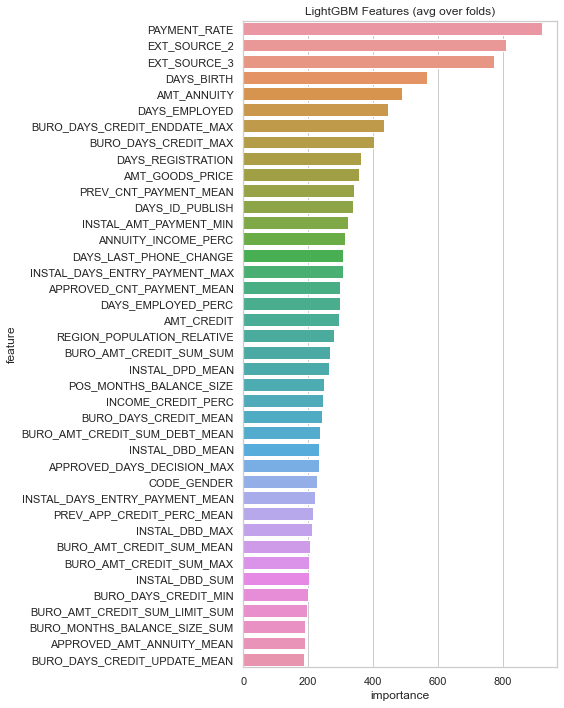

In [118]:
display_importances(feature_importance_df,40)

In [119]:
train_df_lgbmc.shape

(307507, 798)

In [120]:
names_best_features_20_all = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
names_best_features_20_all 

Index(['PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'AMT_ANNUITY', 'DAYS_EMPLOYED', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
       'BURO_DAYS_CREDIT_MAX', 'DAYS_REGISTRATION', 'AMT_GOODS_PRICE',
       'PREV_CNT_PAYMENT_MEAN', 'DAYS_ID_PUBLISH', 'INSTAL_AMT_PAYMENT_MIN',
       'ANNUITY_INCOME_PERC', 'DAYS_LAST_PHONE_CHANGE',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'APPROVED_CNT_PAYMENT_MEAN',
       'DAYS_EMPLOYED_PERC', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE'],
      dtype='object', name='feature')

In [121]:
feats20 = names_best_features_20_all.to_list()
feats20

['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_MAX',
 'DAYS_REGISTRATION',
 'AMT_GOODS_PRICE',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_MIN',
 'ANNUITY_INCOME_PERC',
 'DAYS_LAST_PHONE_CHANGE',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED_PERC',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE']

### LightGBM with 20 best features

In [122]:
feats20 = ['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_MAX',
 'DAYS_REGISTRATION',
 'AMT_GOODS_PRICE',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_PAYMENT_MIN',
 'ANNUITY_INCOME_PERC',
 'DAYS_LAST_PHONE_CHANGE',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED_PERC',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE']

In [123]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve


# LightGBM  with Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code



import re
# Divide in training/validation and test data 
train_df_lgbmcNaN = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_lgbmcNaN = test_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
print("Train shape: {}, test shape: {}".format(train_df_lgbmcNaN.shape, test_df_lgbmcNaN.shape))


# Cross validation model

folds = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df_lgbmcNaN.shape[0])
sub_preds = np.zeros(test_df_lgbmcNaN.shape[0])
feature20_importance_df = pd.DataFrame()

    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df_lgbmcNaN[feats20], train_df_lgbmcNaN['TARGET'])):
    train_x, train_y = train_df_lgbmcNaN[feats20].iloc[train_idx], train_df_lgbmcNaN['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df_lgbmcNaN[feats20].iloc[valid_idx], train_df_lgbmcNaN['TARGET'].iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, class_weight='balanced'  )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df_lgbmcNaN[feats20], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats20
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature20_importance_df = pd.concat([feature20_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))


print('Full AUC score %.6f' % roc_auc_score(train_df_lgbmcNaN['TARGET'], oof_preds))

# Write submission file and plot feature importance
#test_df_lgbmcNaN['TARGET'] = sub_preds
#test_df_lgbmcNaN[['SK_ID_CURR', 'TARGET']].to_csv('test_df_lgbmcNaN_pred.csv', index= False)


Train shape: (172764, 509), test shape: (28861, 507)


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.780976	training's binary_logloss: 0.568774	valid_1's auc: 0.756664	valid_1's binary_logloss: 0.575717
[400]	training's auc: 0.804251	training's binary_logloss: 0.543374	valid_1's auc: 0.761677	valid_1's binary_logloss: 0.558505
[600]	training's auc: 0.82093	training's binary_logloss: 0.526033	valid_1's auc: 0.762855	valid_1's binary_logloss: 0.547805
[800]	training's auc: 0.835779	training's binary_logloss: 0.510378	valid_1's auc: 0.763743	valid_1's binary_logloss: 0.538533
[1000]	training's auc: 0.848976	training's binary_logloss: 0.496305	valid_1's auc: 0.76362	valid_1's binary_logloss: 0.530015
Fold  1 AUC : 0.763870
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.781595	training's binary_logloss: 0.568357	valid_1's auc: 0.753248	valid_1's binary_logloss: 0.58234
[400]	training's auc: 0.805228	training's binary_logloss: 0.542558	valid_1's auc: 0.759306	valid_1's binary_logloss: 0.564721
[600]	training's auc: 0.822342	training's binary_logloss: 0.524891	valid_1's auc: 0.760933	valid_1's binary_logloss: 0.553598
[800]	training's auc: 0.836788	training's binary_logloss: 0.509834	valid_1's auc: 0.76037	valid_1's binary_logloss: 0.544424
Fold  2 AUC : 0.760980
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.780916	training's binary_logloss: 0.568753	valid_1's auc: 0.752026	valid_1's binary_logloss: 0.574055
[400]	training's auc: 0.804416	training's binary_logloss: 0.543399	valid_1's auc: 0.75961	valid_1's binary_logloss: 0.556158
[600]	training's auc: 0.821672	training's binary_logloss: 0.525435	valid_1's auc: 0.760555	valid_1's binary_logloss: 0.545088
Fold  3 AUC : 0.760773
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.782537	training's binary_logloss: 0.567387	valid_1's auc: 0.742603	valid_1's binary_logloss: 0.581368
[400]	training's auc: 0.805828	training's binary_logloss: 0.541946	valid_1's auc: 0.748781	valid_1's binary_logloss: 0.56473
[600]	training's auc: 0.823522	training's binary_logloss: 0.523544	valid_1's auc: 0.749219	valid_1's binary_logloss: 0.553975
[800]	training's auc: 0.838247	training's binary_logloss: 0.507926	valid_1's auc: 0.748066	valid_1's binary_logloss: 0.544892
Fold  4 AUC : 0.749364
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.781681	training's binary_logloss: 0.568264	valid_1's auc: 0.754242	valid_1's binary_logloss: 0.575663
[400]	training's auc: 0.805331	training's binary_logloss: 0.542432	valid_1's auc: 0.759995	valid_1's binary_logloss: 0.558207
[600]	training's auc: 0.821857	training's binary_logloss: 0.525175	valid_1's auc: 0.761229	valid_1's binary_logloss: 0.547203
[800]	training's auc: 0.836596	training's binary_logloss: 0.509685	valid_1's auc: 0.760921	valid_1's binary_logloss: 0.538367
Fold  5 AUC : 0.761332
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.78131	training's binary_logloss: 0.568513	valid_1's auc: 0.755286	valid_1's binary_logloss: 0.576692
[400]	training's auc: 0.804586	training's binary_logloss: 0.543055	valid_1's auc: 0.764054	valid_1's binary_logloss: 0.558385
[600]	training's auc: 0.82118	training's binary_logloss: 0.52588	valid_1's auc: 0.766191	valid_1's binary_logloss: 0.54732
[800]	training's auc: 0.835415	training's binary_logloss: 0.510902	valid_1's auc: 0.76689	valid_1's binary_logloss: 0.537858
[1000]	training's auc: 0.847842	training's binary_logloss: 0.497641	valid_1's auc: 0.766664	valid_1's binary_logloss: 0.529919
Fold  6 AUC : 0.766947
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.780727	training's binary_logloss: 0.569106	valid_1's auc: 0.754843	valid_1's binary_logloss: 0.580844
[400]	training's auc: 0.804451	training's binary_logloss: 0.543515	valid_1's auc: 0.760476	valid_1's binary_logloss: 0.564133
[600]	training's auc: 0.82155	training's binary_logloss: 0.525812	valid_1's auc: 0.761734	valid_1's binary_logloss: 0.553387
[800]	training's auc: 0.835767	training's binary_logloss: 0.510807	valid_1's auc: 0.762016	valid_1's binary_logloss: 0.544274
Fold  7 AUC : 0.762225
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.781383	training's binary_logloss: 0.568477	valid_1's auc: 0.756123	valid_1's binary_logloss: 0.576264
[400]	training's auc: 0.805137	training's binary_logloss: 0.54275	valid_1's auc: 0.760918	valid_1's binary_logloss: 0.558218
Fold  8 AUC : 0.761132
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.78197	training's binary_logloss: 0.56788	valid_1's auc: 0.750934	valid_1's binary_logloss: 0.575903
[400]	training's auc: 0.804918	training's binary_logloss: 0.542847	valid_1's auc: 0.755263	valid_1's binary_logloss: 0.559702
[600]	training's auc: 0.821955	training's binary_logloss: 0.525037	valid_1's auc: 0.75564	valid_1's binary_logloss: 0.548975
Fold  9 AUC : 0.755807
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[200]	training's auc: 0.781655	training's binary_logloss: 0.568396	valid_1's auc: 0.748933	valid_1's binary_logloss: 0.578484
[400]	training's auc: 0.805112	training's binary_logloss: 0.542663	valid_1's auc: 0.754301	valid_1's binary_logloss: 0.561069
[600]	training's auc: 0.822248	training's binary_logloss: 0.524917	valid_1's auc: 0.754393	valid_1's binary_logloss: 0.549984
[800]	training's auc: 0.836556	training's binary_logloss: 0.509862	valid_1's auc: 0.754126	valid_1's binary_logloss: 0.541158
Fold 10 AUC : 0.754610
Full AUC score 0.759644


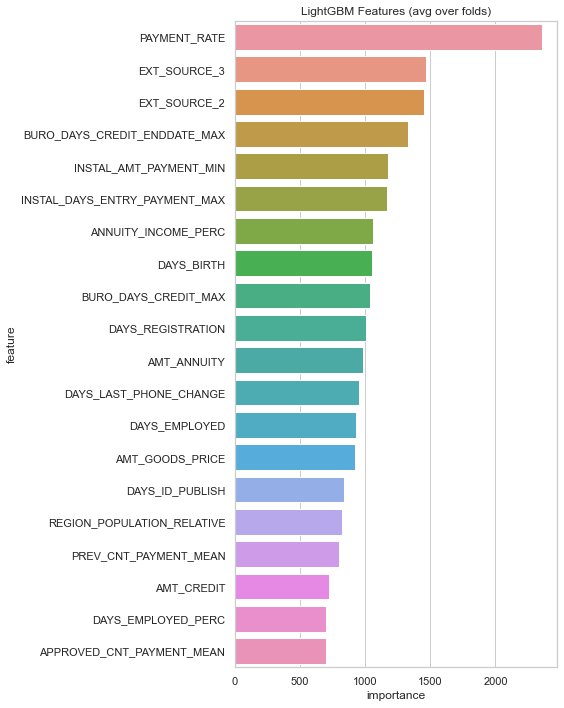

In [124]:
display_importances(feature20_importance_df,20)

In [125]:
best_feat_20 = feature20_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
best_feat_20

,importance
feature,
PAYMENT_RATE,2356.2
EXT_SOURCE_3,1468.5
EXT_SOURCE_2,1454.1
BURO_DAYS_CREDIT_ENDDATE_MAX,1329.4
INSTAL_AMT_PAYMENT_MIN,1175.0
INSTAL_DAYS_ENTRY_PAYMENT_MAX,1164.7
ANNUITY_INCOME_PERC,1059.3
DAYS_BIRTH,1053.9
BURO_DAYS_CREDIT_MAX,1038.4


In [126]:
# On refait tourner le modèle en pipeline pour l'exporter et avoir un X_train

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from lightgbm import LGBMClassifier

import re
# Divide in training/validation and test data 
train_df_lgbmcNaN = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_lgbmcNaN = test_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))



# LightGBM parameters found by Bayesian optimization
lgbm = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,  class_weight='balanced'  )


cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

X20 = train_df_lgbmcNaN [feats20]
y20 = train_df_lgbmcNaN ['TARGET']




model_pipeline_lgbm20 = make_pipeline(lgbm)

X20_train, X20_test, y20_train, y20_test = train_test_split(X20, y20, test_size=0.3,
                                                    random_state=0)
model_pipeline_lgbm20.fit(X20_train, y20_train)

#model_pipeline.score(X_test, y_test)

y20_pred_proba = model_pipeline_lgbm20.predict_proba(X20_test)[:,1]
roc_auc_score(y20_test, y20_pred_proba)


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


0.7304739786829151

In [127]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
y20_pred = model_pipeline_lgbm20.predict(X20_test)
cm = confusion_matrix(y20_test, y20_pred)
cm

array([[43115,  4396],
       [ 2961,  1358]], dtype=int64)

In [128]:
Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])

print(Specificity)
print(Sensitivity)

0.9074740586390521
0.31442463533225284


In [129]:
X20_test_all = pd.merge(X20_test,train_df_lgbmcNaN [feats20+['SK_ID_CURR', 'TARGET']], left_index=True, right_index=True )
X20_test_all['y_pred_proba']=y20_pred_proba
X20_test_all['y_pred']=y20_pred
X20_test_all

,PAYMENT_RATE_x,EXT_SOURCE_2_x,EXT_SOURCE_3_x,DAYS_BIRTH_x,AMT_ANNUITY_x,DAYS_EMPLOYED_x,BURO_DAYS_CREDIT_ENDDATE_MAX_x,BURO_DAYS_CREDIT_MAX_x,DAYS_REGISTRATION_x,AMT_GOODS_PRICE_x,...,DAYS_LAST_PHONE_CHANGE_y,INSTAL_DAYS_ENTRY_PAYMENT_MAX_y,APPROVED_CNT_PAYMENT_MEAN_y,DAYS_EMPLOYED_PERC_y,AMT_CREDIT_y,REGION_POPULATION_RELATIVE_y,SK_ID_CURR,TARGET,y_pred_proba,y_pred
265179,0.051203,0.780771,0.647977,-15866,46579.5,-195.0,347.0,-1115.0,-8306.0,747000.0,...,-2258.0,-20.0,7.0,0.012290,909697.5,0.010276,407110,0.0,0.021231,0.0
123291,0.039776,0.734708,0.633032,-12611,44748.0,-3087.0,413.0,-711.0,-33.0,1125000.0,...,-1212.0,-131.0,6.0,0.244786,1125000.0,0.026392,242977,0.0,0.005716,0.0
125014,0.056343,0.236402,0.579727,-21464,14350.5,-2335.0,-1.0,-261.0,-7722.0,225000.0,...,-1186.0,-16.0,6.0,0.108787,254700.0,0.014464,244980,0.0,0.106265,0.0
212282,0.050000,0.579989,0.595456,-12790,9000.0,-5280.0,31062.0,-44.0,-2442.0,180000.0,...,-201.0,-97.0,12.0,0.412823,180000.0,0.008625,346002,0.0,0.033093,0.0
99731,0.029475,0.601775,0.477649,-20905,16366.5,-984.0,1785.0,-41.0,-7161.0,463500.0,...,-1782.0,-1455.0,12.0,0.047070,555273.0,0.016612,215780,0.0,0.052884,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,0.060647,0.516353,0.572683,-10905,35937.0,-1699.0,564.0,-468.0,-1371.0,450000.0,...,-3190.0,-2.0,10.0,0.155800,592560.0,0.008019,109599,0.0,0.483826,0.0
39807,0.050000,0.655397,0.715103,-23333,18000.0,-10951.0,407.0,-321.0,-9384.0,360000.0,...,-1579.0,-216.0,10.0,0.469335,360000.0,0.026392,146103,0.0,0.094826,0.0
251376,0.050000,0.363391,0.556727,-15947,6750.0,-201.0,50.0,-253.0,-3047.0,135000.0,...,-665.0,-10.0,24.0,0.012604,135000.0,0.035792,390861,0.0,0.322176,0.0
292329,0.032252,0.587243,0.241861,-14983,15529.5,-3732.0,1234.0,-204.0,-3188.0,481500.0,...,-1776.0,-7.0,14.0,0.249082,481500.0,0.009657,438650,0.0,0.206632,0.0


<AxesSubplot:xlabel='y_pred_proba', ylabel='TARGET_cat'>

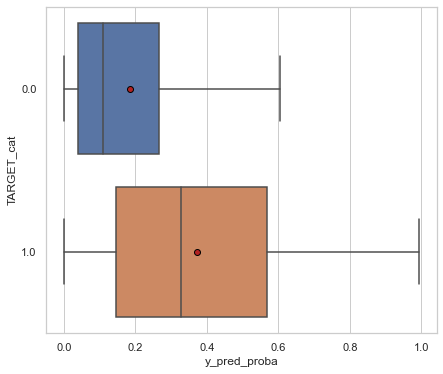

In [130]:
X20_test_all['TARGET_cat'] = X20_test_all['TARGET'].astype('category')

meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
sns.set(style='whitegrid', rc={"figure.figsize":(7, 6)})
sns.boxplot(x="y_pred_proba", y="TARGET_cat", showmeans=True, meanprops=meanprops, data=X20_test_all, showfliers=False )


In [135]:
# On refait tourner le modèle sans pipeline pour shap

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from lightgbm import LGBMClassifier

import re
# Divide in training/validation and test data 
train_df_lgbmcNaN = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_lgbmcNaN = test_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))



# LightGBM parameters found by Bayesian optimization
lgbm20 = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,  class_weight='balanced'  )


cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

X20 = train_df_lgbmcNaN [feats20]
y20 = train_df_lgbmcNaN ['TARGET']



X20_train, X20_test, y20_train, y20_test = train_test_split(X20, y20, test_size=0.3,
                                                    random_state=0)
lgbm20.fit(X20_train, y20_train)

#y20_pred_proba = lgbm20.predict_proba(X20_test)[:,1]
#roc_auc_score(y20_test, y20_pred_proba)


'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


LGBMClassifier(class_weight='balanced', colsample_bytree=0.9497036,
               learning_rate=0.02, max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, nthread=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               silent=-1, subsample=0.8715623, verbose=-1)

### LightGBM  : model interpretation with shape

In [132]:
test_df_lgbmcNaN

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
307511,100001,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7.0
307512,100005,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9.0
307513,100013,0,1,0,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,10897.898516,1689174.270,6.165,357347.745,9740.235774,1509736.545,-14.0,-1358.109677,-210507.0,155.0
307514,100028,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,4979.282257,562658.895,1.170,38988.540,4356.731549,492310.665,-29.0,-858.548673,-97016.0,113.0
307516,100042,1,1,0,0,270000.0,959688.0,34600.5,810000.0,0.025164,...,22120.177995,4025872.395,32.850,1082512.575,21856.803379,3977938.215,-17.0,-1546.208791,-281410.0,182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356248,456189,1,0,0,0,270000.0,360000.0,28570.5,360000.0,0.026392,...,5951.235000,446342.625,21.870,59231.430,5727.646200,429573.465,-24.0,-580.186667,-43514.0,75.0
356249,456202,1,1,1,3,135000.0,252022.5,23112.0,217561.5,0.009175,...,17446.546800,436163.670,1232.505,89155.800,19666.306800,491657.670,-6.0,-297.600000,-7440.0,25.0
356252,456223,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,23158.991250,185271.930,12640.950,81184.005,23158.991250,185271.930,-33.0,-586.375000,-4691.0,8.0
356253,456224,0,0,1,0,225000.0,450000.0,25128.0,450000.0,0.018850,...,17269.234138,500807.790,5519.925,23451.705,17269.234138,500807.790,-13.0,-924.965517,-26824.0,29.0


In [134]:
#client test 
data20 = test_df_lgbmcNaN.loc[test_df_lgbmcNaN['SK_ID_CURR'] == 100128, feats20]
#data20.drop('SK_ID_CURR',axis=1, inplace=True)
data20

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,DAYS_REGISTRATION,AMT_GOODS_PRICE,PREV_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,INSTAL_AMT_PAYMENT_MIN,ANNUITY_INCOME_PERC,DAYS_LAST_PHONE_CHANGE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,APPROVED_CNT_PAYMENT_MEAN,DAYS_EMPLOYED_PERC,AMT_CREDIT,REGION_POPULATION_RELATIVE
307529,0.054549,0.375073,0.347418,-10962,23526.0,-1883.0,10784.0,-156.0,-99.0,360000.0,25.6,-1721,3.51,0.10456,-1616.0,-357.0,23.714286,0.171775,431280.0,0.025164


In [130]:
#!pip install shap

     ------------------------------------- 435.6/435.6 kB 13.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import shap
lgbm20_explainer = shap.TreeExplainer(lgbm20, X20_train)

In [136]:
lgbm20_explainer.shap_values(data20)

array([[ 3.86866936e-01, -2.28521136e-01,  1.33919128e-01,
         1.54294644e+00, -7.63315778e-01, -6.74996706e-01,
         4.03526944e-01,  3.98737335e-01, -1.91301772e-01,
        -2.37876730e-01,  1.66651388e+00, -1.46604732e-01,
         2.09437887e-02, -4.58208387e-04, -9.34965187e-02,
        -2.77951919e-01,  3.06141603e-03, -1.08282039e+00,
         1.35345992e-01,  8.07071409e-01]])

In [137]:
lgbm20_explainer.shap_values(data20)[0]

array([ 3.86866936e-01, -2.28521136e-01,  1.33919128e-01,  1.54294644e+00,
       -7.63315778e-01, -6.74996706e-01,  4.03526944e-01,  3.98737335e-01,
       -1.91301772e-01, -2.37876730e-01,  1.66651388e+00, -1.46604732e-01,
        2.09437887e-02, -4.58208387e-04, -9.34965187e-02, -2.77951919e-01,
        3.06141603e-03, -1.08282039e+00,  1.35345992e-01,  8.07071409e-01])

In [138]:
shap.initjs()

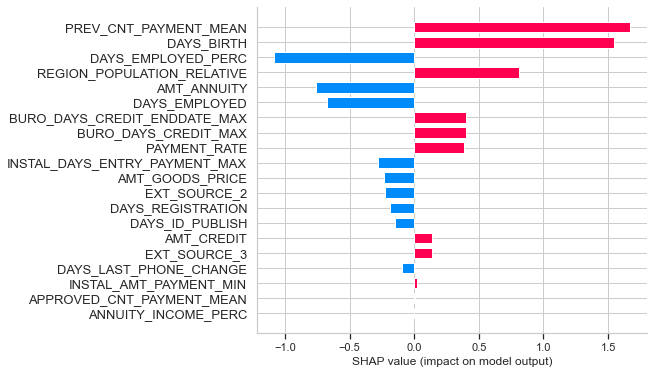

In [139]:
shap.bar_plot(lgbm20_explainer.shap_values(data20)[0], feature_names=feats20, max_display=len(feats20))

In [140]:
shap_values20 = lgbm20_explainer(data20)
shap_values20.feature_names = feats20
shap_values20

.values =
array([[ 3.86866936e-01, -2.28521136e-01,  1.33919128e-01,
         1.54294644e+00, -7.63315778e-01, -6.74996706e-01,
         4.03526944e-01,  3.98737335e-01, -1.91301772e-01,
        -2.37876730e-01,  1.66651388e+00, -1.46604732e-01,
         2.09437887e-02, -4.58208387e-04, -9.34965187e-02,
        -2.77951919e-01,  3.06141603e-03, -1.08282039e+00,
         1.35345992e-01,  8.07071409e-01]])

.base_values =
array([-1.60542425])

.data =
array([[ 5.45492487e-02,  3.75073264e-01,  3.47418227e-01,
        -1.09620000e+04,  2.35260000e+04, -1.88300000e+03,
         1.07840000e+04, -1.56000000e+02, -9.90000000e+01,
         3.60000000e+05,  2.56000000e+01, -1.72100000e+03,
         3.51000000e+00,  1.04560000e-01, -1.61600000e+03,
        -3.57000000e+02,  2.37142857e+01,  1.71775223e-01,
         4.31280000e+05,  2.51640000e-02]])

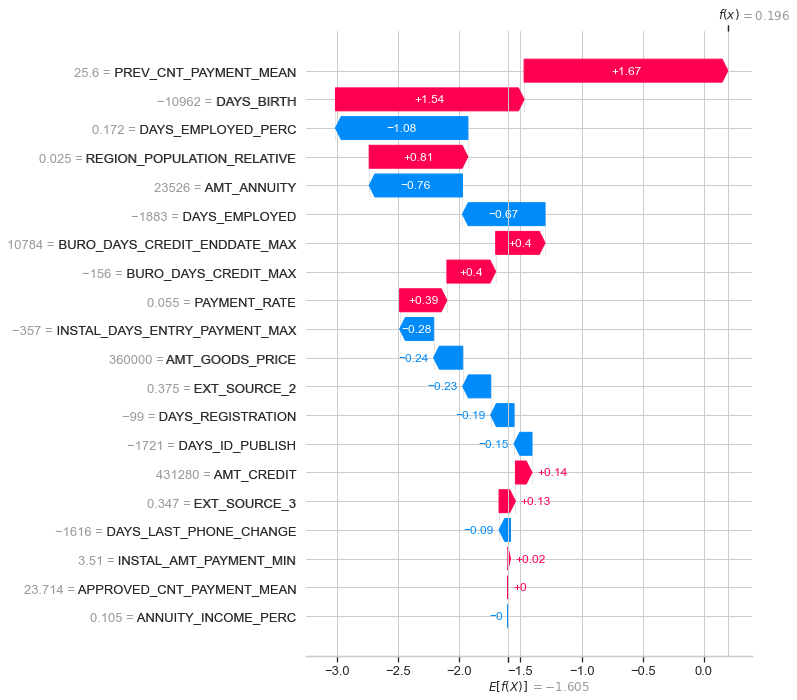

In [141]:
shap.waterfall_plot(shap_values20[0], max_display=len(feats20))

In [201]:
shap.force_plot(lgbm20_explainer.expected_value,
                lgbm20_explainer.shap_values(data20)[0],
                feature_names=feats20,
                            out_names='Payment difficulties')

In [142]:
lgbm20.predict(data20)

array([0.])

In [143]:
data20

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,DAYS_REGISTRATION,AMT_GOODS_PRICE,PREV_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,INSTAL_AMT_PAYMENT_MIN,ANNUITY_INCOME_PERC,DAYS_LAST_PHONE_CHANGE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,APPROVED_CNT_PAYMENT_MEAN,DAYS_EMPLOYED_PERC,AMT_CREDIT,REGION_POPULATION_RELATIVE
307529,0.054549,0.375073,0.347418,-10962,23526.0,-1883.0,10784.0,-156.0,-99.0,360000.0,25.6,-1721,3.51,0.10456,-1616.0,-357.0,23.714286,0.171775,431280.0,0.025164


In [144]:
lgbm20.predict_proba(data20)

array([[0.80606419, 0.19393581]])

### LightGBM  : model interpretation with lime

In [196]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X20_train.values, mode="classification", feature_names= feats20)
explanation = explainer.explain_instance(data20.values[0], model_pipeline_lgbm20.predict_proba, num_features=len(feats20))
explanation.show_in_notebook()

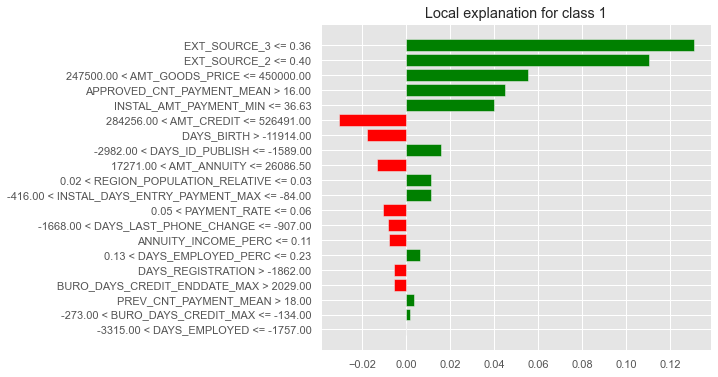

In [146]:
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()

In [148]:
model_pipeline_lgbm20.predict(data20)

array([0.])

In [149]:
model_pipeline_lgbm20.predict_proba(data20)

array([[0.80606419, 0.19393581]])

## Statistiques descriptives par rapport au client

### Datas merge

In [150]:
clients_init = pd.read_csv('application_train.csv')

In [151]:
clients_init.shape

(307511, 122)

In [152]:
clients_init.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [154]:
#On récupère juste les variables catégorielles de départ
categorical_col_mask = clients_init.dtypes=='O'
categorical_col= clients_init.columns[categorical_col_mask].tolist()
#On y ajoute le numéro de clients et la target
categorical_col = categorical_col + ['SK_ID_CURR','TARGET']
categorical_col

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'SK_ID_CURR',
 'TARGET']

In [155]:
clients_init[categorical_col]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,SK_ID_CURR,TARGET
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No,100002,1
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No,100003,0
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN,100004,0
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN,100006,0
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN,100007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No,456251,0
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No,456252,0
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No,456253,0
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No,456254,1


In [80]:
train_df_lgbmc_NaN.shape

(307507, 798)

In [160]:
#On retire les variables 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'
clients_apres = train_df_lgbmcNaN[feats20+['SK_ID_CURR']]
clients_apres

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,DAYS_REGISTRATION,AMT_GOODS_PRICE,...,DAYS_ID_PUBLISH,INSTAL_AMT_PAYMENT_MIN,ANNUITY_INCOME_PERC,DAYS_LAST_PHONE_CHANGE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,APPROVED_CNT_PAYMENT_MEAN,DAYS_EMPLOYED_PERC,AMT_CREDIT,REGION_POPULATION_RELATIVE,SK_ID_CURR
0,0.060749,0.262949,0.139376,-9461,24700.5,-637.0,780.0,-103.0,-3648.0,351000.0,...,-2120,9251.775,0.121978,-1134.0,-49.0,24.00,0.067329,406597.5,0.018801,100002
2,0.050000,0.555912,0.729567,-19046,6750.0,-225.0,-382.0,-408.0,-4260.0,135000.0,...,-2531,5357.250,0.100000,-815.0,-727.0,4.00,0.011814,135000.0,0.010032,100004
5,0.056101,0.354225,0.621226,-16941,27517.5,-1588.0,471.0,-78.0,-4970.0,454500.0,...,-477,227.160,0.277955,-2536.0,-82.0,14.00,0.093737,490495.5,0.035792,100008
6,0.026463,0.724000,0.492060,-13778,41301.0,-3130.0,1402.0,-239.0,-1213.0,1395000.0,...,-619,6155.280,0.241526,-1562.0,-58.0,8.00,0.227174,1560726.0,0.035792,100009
7,0.027500,0.714279,0.540654,-18850,42075.0,-449.0,689.0,-1138.0,-4597.0,1530000.0,...,-2379,27321.390,0.116875,-1070.0,-774.0,10.00,0.023820,1530000.0,0.003122,100010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.047200,0.313334,0.735221,-16063,10620.0,-8736.0,852.0,-154.0,-8672.0,225000.0,...,-4531,29.340,0.112381,-1516.0,-7.0,3.00,0.543859,225000.0,0.010966,456246
307503,0.051433,0.501221,0.609276,-11870,17770.5,-399.0,10617.0,-287.0,-675.0,247500.0,...,-3936,43.830,0.157960,-2315.0,-34.0,7.75,0.033614,345510.0,0.022800,456247
307508,0.044239,0.535722,0.218859,-14966,29979.0,-7921.0,1113.0,-713.0,-6737.0,585000.0,...,-5150,27.270,0.195941,-1909.0,-1738.0,5.00,0.529266,677664.0,0.005002,456253
307509,0.054592,0.514163,0.661024,-11961,20205.0,-4786.0,-859.0,-1104.0,-2562.0,319500.0,...,-931,2296.440,0.118158,-322.0,-18.0,15.00,0.400134,370107.0,0.005313,456254


In [161]:
clients = pd.merge(clients_apres, clients_init[categorical_col], on= 'SK_ID_CURR')
#clients.drop('index', axis=1, inplace=True)
clients

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,DAYS_REGISTRATION,AMT_GOODS_PRICE,...,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,TARGET
0,0.060749,0.262949,0.139376,-9461,24700.5,-637.0,780.0,-103.0,-3648.0,351000.0,...,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No,1
1,0.050000,0.555912,0.729567,-19046,6750.0,-225.0,-382.0,-408.0,-4260.0,135000.0,...,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN,0
2,0.056101,0.354225,0.621226,-16941,27517.5,-1588.0,471.0,-78.0,-4970.0,454500.0,...,Married,House / apartment,Laborers,WEDNESDAY,Other,NaN,NaN,NaN,NaN,0
3,0.026463,0.724000,0.492060,-13778,41301.0,-3130.0,1402.0,-239.0,-1213.0,1395000.0,...,Married,House / apartment,Accountants,SUNDAY,Business Entity Type 3,NaN,NaN,NaN,NaN,0
4,0.027500,0.714279,0.540654,-18850,42075.0,-449.0,689.0,-1138.0,-4597.0,1530000.0,...,Married,House / apartment,Managers,MONDAY,Other,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172759,0.047200,0.313334,0.735221,-16063,10620.0,-8736.0,852.0,-154.0,-8672.0,225000.0,...,Married,House / apartment,Laborers,MONDAY,School,NaN,NaN,NaN,NaN,0
172760,0.051433,0.501221,0.609276,-11870,17770.5,-399.0,10617.0,-287.0,-675.0,247500.0,...,Single / not married,House / apartment,Core staff,SATURDAY,Bank,NaN,NaN,NaN,NaN,0
172761,0.044239,0.535722,0.218859,-14966,29979.0,-7921.0,1113.0,-713.0,-6737.0,585000.0,...,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No,0
172762,0.054592,0.514163,0.661024,-11961,20205.0,-4786.0,-859.0,-1104.0,-2562.0,319500.0,...,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No,1


### Graphics

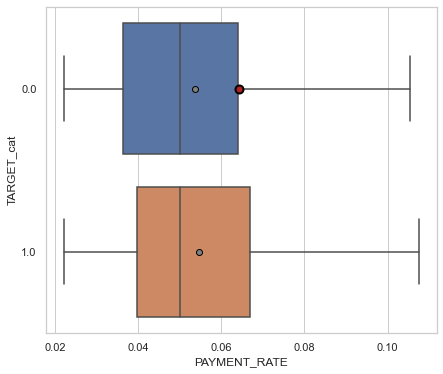

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

num_client=100101
clients['TARGET_cat'] = clients['TARGET'].astype('category')

meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'gray'}
sns.set(style='whitegrid', rc={"figure.figsize":(7, 6)})



ax = sns.boxplot(x="PAYMENT_RATE", y="TARGET_cat", showmeans=True, meanprops=meanprops, data=clients, showfliers = False)
ax = sns.swarmplot(x="PAYMENT_RATE", y="TARGET_cat", data=clients.loc[clients['SK_ID_CURR'] == num_client,:], 
                   color ='firebrick',size=8, linewidth=2, edgecolor='black')

plt.show()

In [178]:
feats20[0]

'PAYMENT_RATE'

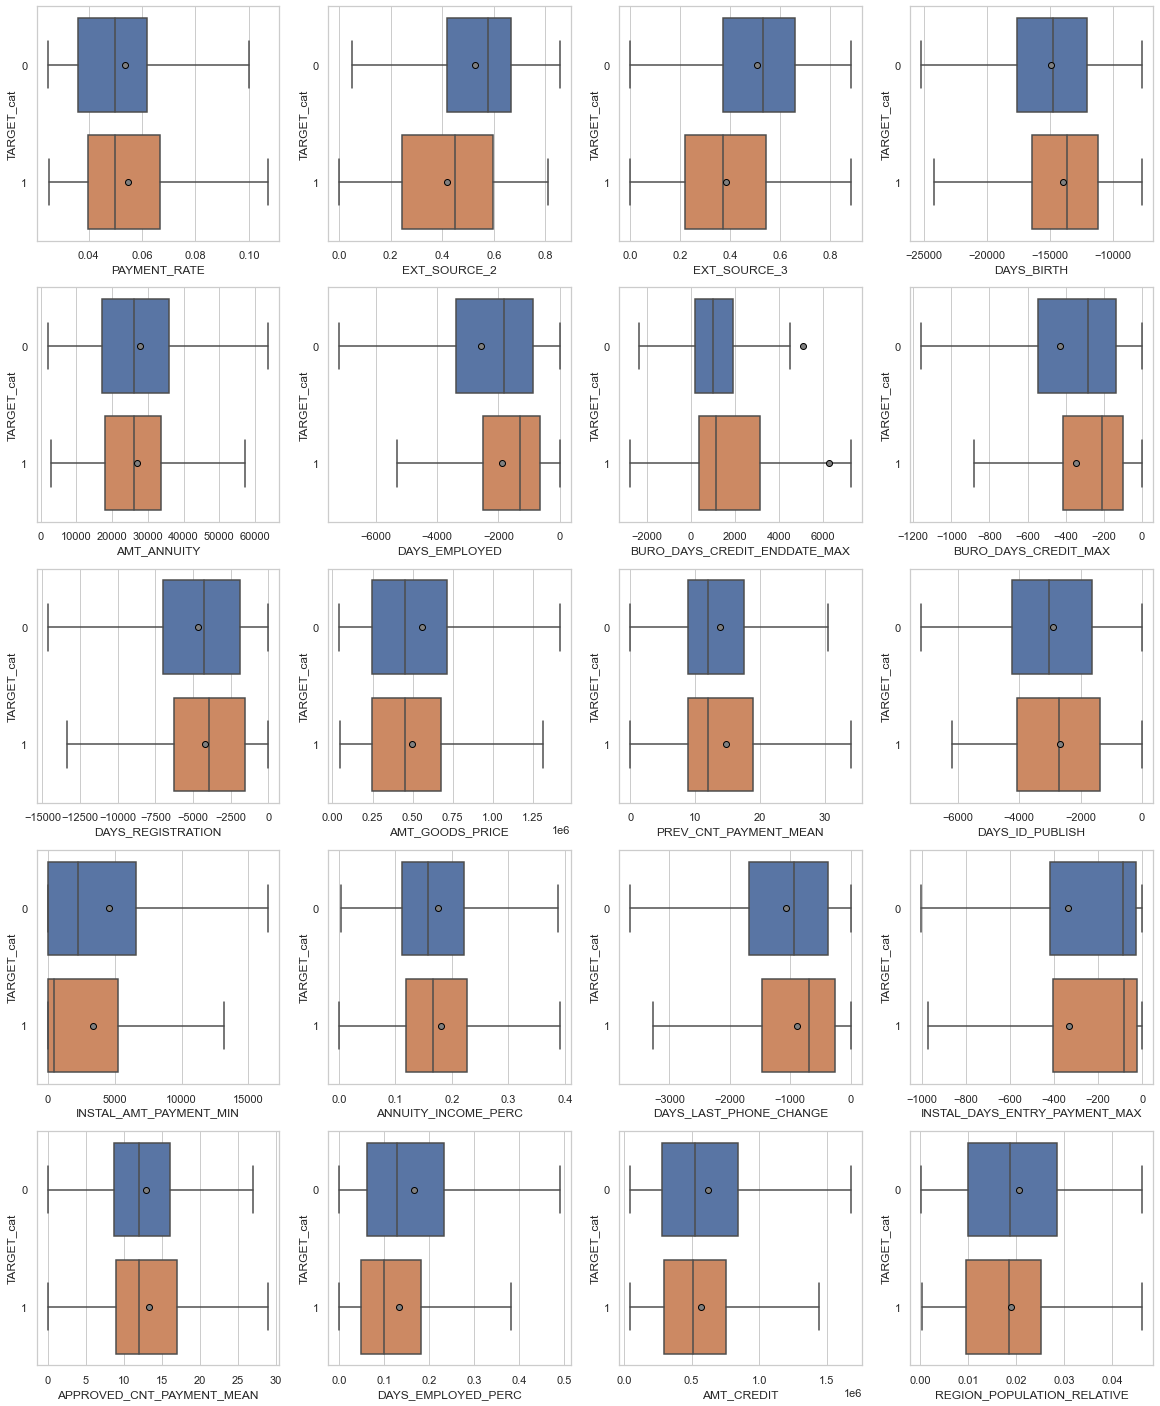

In [195]:
num_client=100101
clients['TARGET_cat'] = clients['TARGET'].astype('category')

meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'gray'}
#sns.set(style='whitegrid', rc={"figure.figsize":(7, 6)})
figure = plt.figure(figsize = (20, 25)) 


for i in range(20):
    plt.subplot(5,4,i+1)
    ax = sns.boxplot(x=feats20[i], y="TARGET_cat", showmeans=True, meanprops=meanprops, data=clients, showfliers = False)
    ax = sns.swarmplot(x=feats20[i], y="TARGET_cat", data=clients.loc[clients['SK_ID_CURR'] == num_client,:], 
                   color ='firebrick',size=8, linewidth=2, edgecolor='black')
plt.show()

## Export du modèle et des fichiers

In [162]:
import joblib
joblib.dump(lgbm20, 'lgbm.joblib')

['lgbm.joblib']

In [163]:
import joblib
joblib.dump(model_pipeline_lgbm20, 'pipeline_bank_lgbm.joblib')

['pipeline_bank_lgbm.joblib']

In [164]:
from mlflow.models.signature import infer_signature
signature = infer_signature(X20_train, y20_train)

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [166]:
#Création fichier des données descriptives relatives aux clients (dont on veut la prédiction)

clients_init = pd.read_csv('application_test.csv')

#On récupère juste les variables catégorielles de départ
categorical_col_mask = clients_init.dtypes=='O'
categorical_col= clients_init.columns[categorical_col_mask].tolist()
#On y ajoute le numéro de clients
categorical_col = categorical_col + ['SK_ID_CURR']


#On retire les variables 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'
clients_apres = test_df_lgbmcNaN[feats20+['SK_ID_CURR']]
clients_apres

#Merge des 2 fichiers pour avoir les variables catégorielles non encodées et les nouvelles features créees
clients_test_descr = pd.merge(clients_apres, clients_init[categorical_col], on= 'SK_ID_CURR')
clients_test_descr

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,DAYS_REGISTRATION,AMT_GOODS_PRICE,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0.036147,0.789654,0.159520,-19241,20560.5,-2329.0,1778.0,-49.0,-5170.0,450000.0,...,Higher education,Married,House / apartment,NaN,TUESDAY,Kindergarten,NaN,block of flats,"Stone, brick",No
1,0.077973,0.291656,0.432962,-18064,17370.0,-4469.0,1324.0,-62.0,-9118.0,180000.0,...,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,FRIDAY,Self-employed,NaN,NaN,NaN,NaN
2,0.105202,0.699787,0.610991,-20038,69777.0,-4458.0,-567.0,-1210.0,-2175.0,630000.0,...,Higher education,Married,House / apartment,Drivers,MONDAY,Transport: type 3,NaN,NaN,NaN,NaN
3,0.031123,0.509677,0.612704,-13976,49018.5,-1866.0,30885.0,-269.0,-2000.0,1575000.0,...,Secondary / secondary special,Married,House / apartment,Sales staff,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
4,0.036054,0.628904,0.392774,-18604,34600.5,-12009.0,8957.0,-234.0,-6116.0,810000.0,...,Secondary / secondary special,Married,House / apartment,Drivers,MONDAY,Government,not specified,block of flats,Block,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28856,0.079363,0.689832,0.255332,-19397,28570.5,-119.0,1388.0,-438.0,-4386.0,360000.0,...,Secondary / secondary special,Separated,Rented apartment,Security staff,SUNDAY,Business Entity Type 3,NaN,block of flats,"Stone, brick",No
28857,0.091706,0.762352,0.240541,-11708,23112.0,-369.0,1122.0,-165.0,-174.0,217561.5,...,Secondary / secondary special,Civil marriage,House / apartment,NaN,TUESDAY,Self-employed,NaN,NaN,NaN,No
28858,0.105414,0.632770,0.283712,-15922,33205.5,-3037.0,-13.0,-218.0,-2681.0,315000.0,...,Secondary / secondary special,Married,House / apartment,NaN,WEDNESDAY,Business Entity Type 3,NaN,block of flats,"Stone, brick",No
28859,0.055840,0.445701,0.595456,-13968,25128.0,-2731.0,980.0,-515.0,-1461.0,450000.0,...,Higher education,Married,House / apartment,Managers,MONDAY,Self-employed,NaN,block of flats,Panel,No


In [167]:
#Export du fichier 'clients_test_descr' en csv et pkl
#Données descriptives des clients dont on veut la prédiction (variables catégorielles non encodées)

#en csv
clients_test_descr.to_csv('clients_test_descr.csv')

#en pkl
import pickle
pickle_out = open("clients_test_descr.pkl", "wb")
pickle.dump(clients_test_descr, pickle_out)
pickle_out.close()

In [168]:
clients['TARGET']

0         1
1         0
2         0
3         0
4         0
         ..
172759    0
172760    0
172761    0
172762    1
172763    0
Name: TARGET, Length: 172764, dtype: int64

In [169]:
#Export du fichier 'clients' en csv et pkl sous le nom de 'clients_train_descr' 
#Les cliens sur lesquels le modèle a été construit

#en csv
clients.to_csv('clients_train_descr.csv')

#en pkl
import pickle
pickle_out = open("clients_train_descr.pkl", "wb")
pickle.dump(clients, pickle_out)
pickle_out.close()

In [170]:
clients_test_descr.shape

(28861, 37)

In [171]:
test_df_lgbmcNaN

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
307511,100001,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7.0
307512,100005,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9.0
307513,100013,0,1,0,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,10897.898516,1689174.270,6.165,357347.745,9740.235774,1509736.545,-14.0,-1358.109677,-210507.0,155.0
307514,100028,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,4979.282257,562658.895,1.170,38988.540,4356.731549,492310.665,-29.0,-858.548673,-97016.0,113.0
307516,100042,1,1,0,0,270000.0,959688.0,34600.5,810000.0,0.025164,...,22120.177995,4025872.395,32.850,1082512.575,21856.803379,3977938.215,-17.0,-1546.208791,-281410.0,182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356248,456189,1,0,0,0,270000.0,360000.0,28570.5,360000.0,0.026392,...,5951.235000,446342.625,21.870,59231.430,5727.646200,429573.465,-24.0,-580.186667,-43514.0,75.0
356249,456202,1,1,1,3,135000.0,252022.5,23112.0,217561.5,0.009175,...,17446.546800,436163.670,1232.505,89155.800,19666.306800,491657.670,-6.0,-297.600000,-7440.0,25.0
356252,456223,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,23158.991250,185271.930,12640.950,81184.005,23158.991250,185271.930,-33.0,-586.375000,-4691.0,8.0
356253,456224,0,0,1,0,225000.0,450000.0,25128.0,450000.0,0.018850,...,17269.234138,500807.790,5519.925,23451.705,17269.234138,500807.790,-13.0,-924.965517,-26824.0,29.0


In [173]:
test_fichier = test_df_lgbmcNaN[feats20+['SK_ID_CURR']]
test_fichier 

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_MAX,DAYS_REGISTRATION,AMT_GOODS_PRICE,...,DAYS_ID_PUBLISH,INSTAL_AMT_PAYMENT_MIN,ANNUITY_INCOME_PERC,DAYS_LAST_PHONE_CHANGE,INSTAL_DAYS_ENTRY_PAYMENT_MAX,APPROVED_CNT_PAYMENT_MEAN,DAYS_EMPLOYED_PERC,AMT_CREDIT,REGION_POPULATION_RELATIVE,SK_ID_CURR
307511,0.036147,0.789654,0.159520,-19241,20560.5,-2329.0,1778.0,-49.0,-5170.0,450000.0,...,-812,3951.000,0.152300,-1740.0,-1628.0,8.000000,0.121044,568800.0,0.018850,100001
307512,0.077973,0.291656,0.432962,-18064,17370.0,-4469.0,1324.0,-62.0,-9118.0,180000.0,...,-1623,4813.200,0.175455,0.0,-470.0,12.000000,0.247398,222768.0,0.035792,100005
307513,0.105202,0.699787,0.610991,-20038,69777.0,-4458.0,-567.0,-1210.0,-2175.0,630000.0,...,-3503,6.165,0.344578,-856.0,-14.0,17.333333,0.222477,663264.0,0.019101,100013
307514,0.031123,0.509677,0.612704,-13976,49018.5,-1866.0,30885.0,-269.0,-2000.0,1575000.0,...,-4208,1.170,0.155614,-1805.0,-29.0,11.333333,0.133515,1575000.0,0.026392,100028
307516,0.036054,0.628904,0.392774,-18604,34600.5,-12009.0,8957.0,-234.0,-6116.0,810000.0,...,-2027,32.850,0.128150,-1705.0,-17.0,21.111111,0.645506,959688.0,0.025164,100042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356248,0.079363,0.689832,0.255332,-19397,28570.5,-119.0,1388.0,-438.0,-4386.0,360000.0,...,-2945,21.870,0.105817,-1252.0,-24.0,8.000000,0.006135,360000.0,0.026392,456189
356249,0.091706,0.762352,0.240541,-11708,23112.0,-369.0,1122.0,-165.0,-174.0,217561.5,...,-4178,1232.505,0.171200,-987.0,-6.0,7.600000,0.031517,252022.5,0.009175,456202
356252,0.105414,0.632770,0.283712,-15922,33205.5,-3037.0,-13.0,-218.0,-2681.0,315000.0,...,-1504,12640.950,0.163978,-838.0,-33.0,11.000000,0.190742,315000.0,0.026392,456223
356253,0.055840,0.445701,0.595456,-13968,25128.0,-2731.0,980.0,-515.0,-1461.0,450000.0,...,-1364,5519.925,0.111680,-2308.0,-13.0,17.000000,0.195518,450000.0,0.018850,456224


In [174]:
#Export du fichier 'test_df_lgbmcNaN' en pkl sous le nom de 'clients_test_pred'
#Déja importé en csv
#Les clients dont on veut la prédiction

pickle_out = open("clients_test_pred.pkl", "wb")
pickle.dump(test_fichier, pickle_out)
pickle_out.close()


In [176]:
#Export du X_train en pkl pour l'utilisation de lime
pickle_out = open("X_train.pkl", "wb")
pickle.dump(X20_train.values, pickle_out)
pickle_out.close()

In [175]:
X20_train.shape

(120934, 20)